<a href="https://colab.research.google.com/github/armandossrecife/my_validation3/blob/main/my_analysis_activemq.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup do Ambiente de Análise

In [1]:
!rm -rf *.log
!rm -rf *.txt
!rm -rf *.xlsx
!rm -rf my_issues
!rm -rf activemq

In [2]:
print('Install Pydriller.')
!pip install pydriller > install_pydriller.log
print('Install gitpython.')
!pip3 install gitpython > install_gitpython.log
print('Install Jira Python lib.')
!pip install jira > install_jira_python.log
print('All depenpencies installed!')
!cat *.log > install.log
print('Details in install.log')

Install Pydriller.
Install gitpython.
Install Jira Python lib.
Install SQLite in Linux


debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
All depenpencies installed!
Details in install.log


## Importa bibliotecas necessárias

In [35]:
import os
from datetime import datetime, timedelta
import tqdm
from pydriller import Repository
from jira import JIRA
import pandas as pd
import re
import scipy.stats as stats
import random
import shutil
import time
from matplotlib import pyplot

## Variáveis Globais

In [36]:
my_repository = 'activemq'
url_to_repository = 'https://github.com/apache/activemq.git'
os.environ['MY_REPOSITORY'] = url_to_repository
os.environ['MY_PATH_REPOSITORY'] = my_repository

JIRA_SERVER = 'https://issues.apache.org/jira'
ISSUE_TRACKER_PROJECT = 'AMQ'

# Credentials
os.environ['USERNAME'] = 'armandossrecife'
os.environ['PASSWORD'] = 'sky1979#ce'
username = os.environ.get('USERNAME')
password = os.environ.get('PASSWORD')


path_to_repository = 'activemq'

arquivos_activemq_by_sysrepoanalysis = ['BrokerService.java',
 'DemandForwardingBridgeSupport.java',
 'MessageDatabase.java',
 'Queue.java',
 'TopicSubscription.java',
 'TransportConnector.java']

lista_arquivos_criticos = ['DemandForwardingBridgeSupport.java',
'SubQueueSelectorCacheBroker.java',
'BrokerServiceAware.java',
'TransportConnector.java',
'BrokerService.java',
'TopicSubscription.java',
'QueueBrowserSubscription.java',
'Queue.java',
'DurableTopicSubscription.java',
'QueueSubscription.java',
'QueueDispatchSelector.java',
'PendingQueueMessageStoragePolicy.java',
'MirroredQueue.java',
'MessageQueue.java']


## Clona o Repositório

In [5]:
print(f'Clona o repositório : {url_to_repository}')
!git clone $MY_REPOSITORY

Clona o repositório : https://github.com/apache/activemq.git
Cloning into 'activemq'...
remote: Enumerating objects: 237915, done.
remote: Counting objects: 100% (4688/4688), done.
remote: Compressing objects: 100% (2235/2235), done.
remote: Total 237915 (delta 2038), reused 4257 (delta 1787), pack-reused 233227
Receiving objects: 100% (237915/237915), 61.60 MiB | 16.58 MiB/s, done.
Resolving deltas: 100% (115027/115027), done.
Updating files: 100% (5318/5318), done.


In [6]:
!cd $MY_PATH_REPOSITORY && git log --pretty="%H %s" > all_commits_msg.txt
!cd $MY_PATH_REPOSITORY && git log --pretty="%H;%ai;%s" > all_commits_full.txt

# Dados do 1o commit e do ultimo commit
!echo "Último commit: "
!head /content/$MY_PATH_REPOSITORY/all_commits_full.txt -n 1
!echo "Primeiro commit: "
!tail /content/$MY_PATH_REPOSITORY/all_commits_full.txt -n 1

Último commit: 
dcf86d391640b0292d0609412b67ab363b17b5a0;2023-11-22 13:59:46 +0100;Merge pull request #1123 from hyteio/AMQ-9398
Primeiro commit: 
40a7d3b6ac35d2ecb34e85fc3403d2e48e33874e;2005-12-12 17:53:59 +0000;Moved the trunk code into the trunk sub directory


## Funções de apoio

In [37]:
def get_all_commits_by_range(initial_date, final_date, repository_name):
  """Extracts information from a date range of commits
  Args:
      initial_date: inicial date of commits
      final_date: final date of commits
  Returns:
        A dictionary of commits, where the keys are the commit hashes and the
        values are tuples containing the commit message, commit's date, commit's line, commit's file, a list of files modified in the commit, a list of all diffs from modified files
  """
  dict_commit_modified_files = {}
  print('Wait...')
  my_traverser_commits = Repository(repository_name, since=initial_date, to=final_date).traverse_commits()
  total_commits = len(list(my_traverser_commits))
  try:
    for commit in tqdm.tqdm(Repository(repository_name, since=initial_date, to=final_date).traverse_commits(), total=total_commits, desc="Progress commit anlysis"):
      list_of_modified_files = []
      list_dict_of_diff_modified_files = []
      for m in commit.modified_files:
        dict_m_diff = {}
        if m is not None:
          list_of_modified_files.append(m.filename)
          dict_m_diff[m.filename] = m.diff
          list_dict_of_diff_modified_files.append(dict_m_diff)
      data_commit = str(commit.committer_date.day) + '/' + str(commit.committer_date.month) + '/' + str(commit.committer_date.year)
      element = commit.msg, data_commit, commit.lines, commit.files, list_of_modified_files, list_dict_of_diff_modified_files
      dict_commit_modified_files[commit.hash] = element
  except Exception as ex:
    print(f'Erro during travesse commits: {str(ex)}')
  return dict_commit_modified_files, total_commits

def get_commits_by_range_and_critical_files(initial_date, final_date, critical_files, repository_name):
  """Extracts information from a date range of commits, focusing on critical files.
  Args:
      initial_date: inicial date of commits
      final_date: final date of commits
      critical_files: A list of critical file paths. ex: ['StorageService.java', 'ColumnFamilyStore.java']
  Returns:
        A dictionary of commits, where the keys are the commit hashes and the
        values are tuples containing the commit message, commits's date, commit's line, commit's file, a list of critical files modified in the commit, a list_of_modified_files, a dictionary of diff [filename]:filename.diff, a list of all diffs from modified files
        commit.msg, data_commit, commit.lines, commit.files, list_of_critical_files_modified, list_of_modified_files, list_dict_of_diff_files, list_dict_of_diff_modified_files
  """

  dict_commit_modified_files = {}
  print('Wait...')
  my_traverser_commits = Repository(repository_name, since=initial_date, to=final_date).traverse_commits()
  total_commits = len(list(my_traverser_commits))
  try:
    for commit in tqdm.tqdm(Repository(repository_name, since=initial_date, to=final_date).traverse_commits(), total=total_commits, desc="Progress critical files commit anlysis"):
      list_of_critical_files_modified = []
      list_of_modified_files = []
      list_dict_of_diff_files = []
      list_dict_of_diff_modified_files = []
      for m in commit.modified_files:
        dict_diff_file = {}
        list_of_modified_files.append(m.filename)
        list_dict_of_diff_modified_files.append(m.diff)
        if m.filename in critical_files:
          list_of_critical_files_modified.append(m.filename)
          dict_diff_file[m.filename] = m.diff
          list_dict_of_diff_files.append(dict_diff_file)
      if len(list_of_critical_files_modified) > 0:
        data_commit = str(commit.committer_date.day) + '/' + str(commit.committer_date.month) + '/' + str(commit.committer_date.year)
        element = commit.msg, data_commit, commit.lines, commit.files, list_of_critical_files_modified, list_of_modified_files, list_dict_of_diff_files, list_dict_of_diff_modified_files
        dict_commit_modified_files[commit.hash] = element
  except Exception as ex:
    print(f'Erro during travesse commits: {str(ex)}')
  return dict_commit_modified_files, total_commits

class JiraIssue:
  def __init__(self, key, summary, issue_type, status, priority, description, comments, created_date=None, updated_date=None, resolved_date=None):
    self.key = key
    self.summary = summary
    self.issue_type = issue_type
    self.status = status
    self.priority = priority
    self.description = description
    self.comments = comments
    self.created_date = created_date
    self.updated_date = updated_date
    self.resolved_date = resolved_date

  def get_comments(self):
    return self.comments

  def __str__(self):
    return (f'Key: {self.key}, Summary: {self.summary}, Type: {self.issue_type}, Status: {self.status}')

class JiraIssues:
  def __init__(self,project, issues):
    self.project = project
    self.issues = issues

  def add_issue(self, issue):
    self.issues.append(issue)

  def get_issues(self) -> list:
    return self.issues

  def update_issues(self, issues):
    self.issues = issues

  def __str__(self):
    str_issues = ""
    for issue in self.get_issues():
      str_issues = str_issues + str(issue)
      str_issues = str_issues + ', '
    str_issues = '[' + str_issues + ']'
    return (f'Project: {self.project}, Qdt of issues: {len(self.issues)}, Issues: {str_issues}')

# Classe de utilidades para manipular o servidor Jira
class JiraUtils:
  def __init__(self, project, jira_instance):
    self.project = project
    self.jira_jira_instance = jira_instance

  def generate_intervals_between_dates(self, date1: tuple, date2: tuple, distance=120) -> list:
    start_date = datetime(date1[0], date1[1], date1[2])
    end_date = datetime(date2[0], date2[1], date2[2])
    interval_days = distance
    # Initialize a list to store the intervals
    intervals = []
    # Initialize the current date as the start date
    current_date = start_date
    # Loop to generate intervals until the current date is less than or equal to the end date
    while current_date < end_date:
        interval = (current_date, current_date + timedelta(days=interval_days - 1))
        intervals.append(interval)
        current_date += timedelta(days=interval_days)
    return intervals

  def convert_interval_dates(self, dates: list) -> list:
    list_interval_dates = []
    for each in dates:
      date1 = each[0]
      # Convert the date to a string in the format "YYYY/MM/DD".
      str_date1 = date1.strftime("%Y/%m/%d")
      date2 = each[1]
      str_date2 = date2.strftime("%Y/%m/%d")
      elemento = str_date1, str_date2
      list_interval_dates.append(elemento)
    return list_interval_dates

  def generate_list_of_sentences(self, dates: list) -> list:
    lista_sentencas = []
    for each in dates:
      str_date1 = each[0].strftime("%Y/%m/%d")
      str_date2 = each[1].strftime("%Y/%m/%d")
      sentenca = f'project={self.project.upper()} and created>="{str_date1}" and created<="{str_date2}"'
      lista_sentencas.append(sentenca)
    return lista_sentencas

  def get_list_of_block_issues_by_dates(self,date1, date2, distance=120) -> list:
    print('Aguarde...')
    t1 = datetime.now()
    list_of_dates = self.generate_intervals_between_dates(date1,date2,distance)
    lista_sentencas = self.generate_list_of_sentences(list_of_dates)
    lista_bloco_issues_by_date = []
    total_items = len(lista_sentencas)
    i = 0
    iterable_lista_sentencas = tqdm.tqdm(lista_sentencas, total=total_items)
    for each in iterable_lista_sentencas:
      issues_by_date_temp = self.jira_jira_instance.search_issues(each,maxResults=1000)
      print(f'Range: {each}, qtd issues: {len(issues_by_date_temp)}')
      lista_bloco_issues_by_date.append(issues_by_date_temp)
      percentage = (i + 1) / total_items * 100
      iterable_lista_sentencas.set_description(f"Progress Message Analysis")
    i += 1
    t2 = datetime.now()
    print(t2)
    print(f'Tempo da consulta: {t2-t1}')
    return lista_bloco_issues_by_date

  def concatenate_block_of_issues(self,block_of_issues):
    concatenated_list = [item for sublist in block_of_issues for item in sublist]
    print(f'Total de issues recuperados: {len(concatenated_list)}')
    return concatenated_list

def analyze_jira_all_issues(project, all_issues):
    """Extracts all issues from Issue Tracker
        Args:
          project: Issue Tracker Project name, example: CASSANDRA
          all_issues: a block of issues
        Returns:
          A list of JiraIssues
    """
    # Create an instance of JiraIssues to manage all issues
    my_all_issues = JiraIssues(project, [])
    total_items = len(all_issues)

    # Iterate through the fetched issues
    for issue in tqdm.tqdm(all_issues, total=total_items, desc='Progress jira all issues analysis'):
        issue_key = issue.key
        issue_summary = issue.fields.summary
        issue_description = issue.fields.description
        issue_comments = [comment.body for comment in issue.fields.comment.comments]
        issue_created_date = issue.fields.created
        issue_updated_date = None
        issue_resolved_date = issue.fields.resolutiondate

        # Check for SATD keywords in the issue's summary, description, and comments
        if issue_summary is None:
            issue_summary = ""
        if issue_description is None:
            issue_description = ""
        if issue_comments is None:
            issue_comments = ""
        if issue_created_date == None:
            issue_created_date = ""
        if issue_updated_date == None:
            issue_updated_date = ""
        if issue_resolved_date == None:
            issue_resolved_date = ""

        issue_type = issue.fields.issuetype.name
        issue_status = issue.fields.status.name
        issue_priority = issue.fields.priority.name

        # Create a JiraIssue instance for the SATD issue
        my_issue = JiraIssue(issue_key, issue_summary, issue_type, issue_status, issue_priority, issue_description, issue_comments, issue_created_date, issue_updated_date, issue_resolved_date)

        my_all_issues.add_issue(my_issue)

    return my_all_issues

def convert_date_jira_to_datetime(jira_date):
  regex = r"(\d{4})-(\d{2})-(\d{2})"
  match = re.match(regex, jira_date)

  if match:
      year, month, day = match.groups()
      datetime_object = datetime(year=int(year), month=int(month), day=int(day))
      return datetime_object
  else:
      return None

def convert_issues_to_dataframe(all_real_issues):
  l_issue_key_aux, l_issue_type_aux, l_issue_summary_aux, l_issue_description_aux, l_issue_status_aux, l_issue_priority_aux, l_issue_comments_aux = [], [], [], [], [], [], []
  l_issue_created_date, l_issue_resolved_date = [], []

  for issue in all_real_issues.get_issues():
    l_issue_key_aux.append(issue.key)
    l_issue_type_aux.append(issue.issue_type)
    l_issue_summary_aux.append(issue.summary)
    l_issue_description_aux.append(issue.description)
    l_issue_status_aux.append(issue.status)
    l_issue_priority_aux.append(issue.priority)
    texto_aux = ""
    for item in issue.get_comments():
      texto_aux = texto_aux + str(item) + "\n"
    l_issue_comments_aux.append(texto_aux)
    created_date_temp = convert_date_jira_to_datetime(issue.created_date)
    l_issue_created_date.append(created_date_temp)
    resolved_date_temp = convert_date_jira_to_datetime(issue.resolved_date)
    l_issue_resolved_date.append(resolved_date_temp)

  dict_all_reall_issues_in_commits_detailed = {
  'issue_key': l_issue_key_aux,
  'issue_type':l_issue_type_aux,
  'status':l_issue_status_aux,
  'priority':l_issue_priority_aux,
  'summary':l_issue_summary_aux,
  'description':l_issue_description_aux,
  'comments':l_issue_comments_aux,
  'created_date': l_issue_created_date,
  'resolved_date': l_issue_resolved_date
  }

  df_all_reall_issues_in_commits_detailed = pd.DataFrame(dict_all_reall_issues_in_commits_detailed)
  return df_all_reall_issues_in_commits_detailed

def convert_commits_to_dataframe(dict_of_commits):
  '''
  v[0] = commit.msg,
  v[1] = data_commit,
  v[2] = commit.lines,
  v[3] = commit.files,
  v[4] = list_of_critical_files_modified,
  v[5] = list_of_modified_files,
  v[6] = list_dict_of_diff_files,
  v[7] = list_dict_of_diff_modified_files
  '''
  l_commit_hash, l_commit_msg, l_commit_data, l_commit_lines, l_commit_files, l_commit_critical_files, l_commit_modified_fies, l_commit_diff_files, l_commit_diff_modified_files = [], [], [], [], [], [], [], [], []
  for k, v in dict_of_commits.items():
    l_commit_hash.append(k)
    if v[0] is not None:
      l_commit_msg.append(v[0])
    if v[1] is not None:
      l_commit_data.append(v[1])
    if v[2] is not None:
      l_commit_lines.append(v[2])
    if v[3] is not None:
      l_commit_files.append(v[3])
    if v[4] is not None:
      l_commit_critical_files.append(v[4])
    if v[5] is not None:
      l_commit_modified_fies.append(v[5])
    if v[6] is not None:
      l_commit_diff_files.append(v[6])
    if v[7] is not None:
      l_commit_diff_modified_files.append(v[7])

  dict_of_commits_aux = {
      'hash': l_commit_hash,
      'msg': l_commit_msg,
      'date': l_commit_data,
      'lines': l_commit_lines,
      'files': l_commit_files,
      'critical_files': l_commit_critical_files,
      'modified_files': l_commit_modified_fies,
      'diff_files': l_commit_diff_files,
      'diff_files_modified_files': l_commit_diff_modified_files
  }

  df_commits = pd.DataFrame(dict_of_commits_aux)
  return df_commits

def convert_commits_to_dataframe2(dict_of_commits):
  '''
  v[0] = commit.msg,
  v[1] = data_commit,
  v[2] = commit.lines,
  v[3] = commit.files,
  v[4] = list_of_files_modified,
  v[5] = list_of_diff_modified_files,
  '''
  l_commit_hash, l_commit_msg, l_commit_data, l_commit_lines, l_commit_files, l_commit_modified_files, l_commit_diff_modified_fies = [], [], [], [], [], [], []
  for k, v in dict_of_commits.items():
    l_commit_hash.append(k)
    if v[0] is not None:
      l_commit_msg.append(v[0])
    if v[1] is not None:
      l_commit_data.append(v[1])
    if v[2] is not None:
      l_commit_lines.append(v[2])
    if v[3] is not None:
      l_commit_files.append(v[3])
    if v[4] is not None:
      l_commit_modified_files.append(v[4])
    if v[5] is not None:
      l_commit_diff_modified_fies.append(v[5])

  dict_of_commits_aux = {
      'hash': l_commit_hash,
      'msg': l_commit_msg,
      'date': l_commit_data,
      'lines': l_commit_lines,
      'files': l_commit_files,
      'modified_files': l_commit_modified_files,
      'diff_modified_files': l_commit_diff_modified_fies,
  }

  df_commits = pd.DataFrame(dict_of_commits_aux)
  return df_commits


def find_issues_id_by_project(input_string: str, project: str) -> list[str]:
    """Finds all Cassandra issue ID patterns in the input string.
    Args:
        input_string: The input string.
        project: The pattern related to project name, for example: CASSANDRA project name
    Returns:
        A list of project issue IDs, if found; otherwise, an empty list.
    """
    # Try to find all Cassandra issue ID patterns in the input string
    matches = re.findall(r"({0}-\d+)".format(project), input_string)
    # Return an empty list if no matches are found
    if not matches:
        return []
    # Convert the list of matches to a set to remove duplicates
    set_matches = set(matches)
    # Convert the set of matches back to a list
    list_unique_matches = list(set_matches)

    # Return the list of matched Cassandra issue IDs
    return list_unique_matches

def get_commits_with_critical_files_and_issues_in_this_commits(df_commits_with_critical_files):
  dict_issues_in_commits = {}
  for index in df_commits_with_critical_files.index:
    l_issues_in_commit = find_issues_id_by_project(input_string=df_commits_with_critical_files.msg[index], project=ISSUE_TRACKER_PROJECT)
    if len(l_issues_in_commit) > 0:
      commit_hash = df_commits_with_critical_files.hash[index]
      dict_issues_in_commits[commit_hash] = l_issues_in_commit

  list_issue_commits, list_issue_issues = [], []
  for k, v in dict_issues_in_commits.items():
    list_issue_commits.append(k)
    for issue in v:
      if issue not in list_issue_issues:
        list_issue_issues.append(issue)

  df_aux  = df_all_reall_issues_in_commits_detailed.copy()
  df_issues_in_commits_with_critical_classes = df_aux[df_aux['issue_key'].isin(list_issue_issues)]

  return dict_issues_in_commits, df_issues_in_commits_with_critical_classes

def calculate_sample_size(confidence_level, margin_of_error, population_proportion, population_size):
    # Calculate the Z-score for the given confidence level
    z_score = stats.norm.ppf(1 - (1 - confidence_level) / 2)

    # Calculate the sample size formula
    sample_size = ((z_score**2) * population_proportion * (1 - population_proportion)) / (margin_of_error**2)

    # Adjust for finite population
    if population_size:
        sample_size = sample_size / (1 + ((sample_size - 1) / population_size))

    return int(sample_size)

def get_max_n_chars(text, max_n):
  text_length = len(text)
  if text_length <= max_n:
    return text
  else:
    return text[:max_n]

def create_new_file(filename, dir_name, issue_type, summary, description, status, comments):
  try:
    filename = dir_name + '/' + filename

    if issue_type is None:
      issue_type = ''
    if summary is None:
      summary = ''
    if description is None:
      description = ''
    if status is None:
      status = ''
    if comments is None:
      comments = ''

    with open(filename, mode='w') as f_issue:
      f_issue.write(f'issue_type: {issue_type} \n')
      f_issue.write(f'summary: {summary} \n')
      f_issue.write(f'description: {get_max_n_chars(text=description, max_n=1000)} \n')
      f_issue.write(f'status: {status} \n')
      f_issue.write(f'comments: {get_max_n_chars(text=comments, max_n=4000)} \n')
    print(f'File {filename} created with success!')

  except Exception as ex:
    print(f'Erro ao criar arquivo: {str(ex)}')

# Seleciona randomicamente os issues para inspeção
def select_issues_to_inspection(sample_size, df_issues_in_commits_with_critical_classes, my_date='02/11/2023'):
  lista_issues_inspecao = []
  dict_issues_para_inspecao = {}
  list_issue_key = df_issues_in_commits_with_critical_classes.issue_key.to_list()
  list_issue_key = list(set(list_issue_key))
  sample_issues = random.choices(list_issue_key, k=sample_size)
  dict_issues_para_inspecao['02/11/2023'] = sample_issues
  print(f'{len(sample_issues)} para inspeção manual')

  date_file_name = my_date.split('/')
  date_file_name = date_file_name[0] + date_file_name[1] + date_file_name[2]
  file_name = 'issues_inspecao_' + date_file_name + '.txt'
  with open(file_name, mode='w') as f_temp:
    for v in dict_issues_para_inspecao[my_date]:
      elemento = v + ','
      f_temp.write(elemento)
  print(f'Relação de Issues salvos em {my_date} para inspeção.')
  return sample_issues

# Gera os arquivos .txt de cada issue selecionado para inspeção
def generate_files_issues_to_inspection(sample_issues, df_issues_in_commits_with_critical_classes):
  contador = 0
  my_dir_name = 'my_issues'
  if not os.path.exists(my_dir_name):
    os.makedirs(my_dir_name)

  total_of_issues = df_issues_in_commits_with_critical_classes.shape[0]
  for index in tqdm.tqdm(df_issues_in_commits_with_critical_classes.index, total=total_of_issues, desc='Analyzing issues'):
    for issue in sample_issues:
      if df_issues_in_commits_with_critical_classes.issue_key[index] == issue:
        create_new_file(filename=df_issues_in_commits_with_critical_classes.issue_key[index], dir_name=my_dir_name, issue_type=df_issues_in_commits_with_critical_classes.issue_type[index], summary=df_issues_in_commits_with_critical_classes.summary[index], description=df_issues_in_commits_with_critical_classes.description[index], status=df_issues_in_commits_with_critical_classes.status[index], comments=df_issues_in_commits_with_critical_classes.comments[index])
        contador += 1
  print(f'Foram criados {contador} arquivos para inspeção')

class SATDCommitAnalyzer:
    def __init__(self, path_to_repository):
        self.path_to_repository = path_to_repository

    @staticmethod
    def is_java_comment(line):
        """Checks if a line is a single-line Java comment.
        Args:
          line: The line to check.
        Returns:
          True if the line is a single-line Java comment, False otherwise.
        """
        # Regular expression pattern to match Java comments
        comment_pattern = r'^\s*//|^\s*/\*|^\s*\*|^\s*\*/'
        # Use the re.match function to check if the line matches the comment pattern
        return bool(re.match(comment_pattern, line))

    def analyze_commits_for_satd(self, start_date, end_date, satd_keywords):
        """Analyzes commits for SATD by checking if the commit message contains any of the specified SATD keywords.
        Args:
          start_date: The start date of the date range to analyze commits within.
          end_date: The end date of the date range to analyze commits within.
          satd_keywords: A list of SATD keywords to search for in commit messages.
        Returns:
          A tuple containing two sets:
            * A set of commit hashes that contain SATD keywords in their commit messages.
            * A dictionary mapping commit hashes to their associated commit messages.
        """
        # Initialize sets to store commits and their associated SATD keywords
        commits_with_satd = set()
        dict_commit_msg = {}

        # Traverse commits within the specified date range
        print('Aguarde...')
        my_traverser_commits = Repository(self.path_to_repository, since=start_date, to=end_date).traverse_commits()
        total_commits = len(list(my_traverser_commits))

        for commit in tqdm.tqdm(Repository(self.path_to_repository, since=start_date, to=end_date).traverse_commits(), total=total_commits, desc="Progress SATD message commit analysis"):
            for keyword in satd_keywords:
                if keyword in commit.msg:
                    commits_with_satd.add(commit.hash)
                    dict_commit_msg[commit.hash] = commit.msg

        return commits_with_satd, dict_commit_msg

    def analyze_commits_for_no_satd(self, start_date, end_date, satd_keywords):
        """Analyzes commits for NO SATD by checking if the commit message does contain any of the specified SATD keywords.
        Args:
          start_date: The start date of the date range to analyze commits within.
          end_date: The end date of the date range to analyze commits within.
          satd_keywords: A list of SATD keywords to search for in commit messages.
        Returns:
          A tuple containing two sets:
            * A set of commit hashes that contain SATD keywords in their commit messages.
            * A dictionary mapping commit hashes to their associated commit messages.
        """
        # Initialize sets to store commits and their associated SATD keywords
        commits_with_satd = set()
        dict_commit_msg = {}

        # Traverse commits within the specified date range
        print('Aguarde...')
        my_traverser_commits = Repository(self.path_to_repository, since=start_date, to=end_date).traverse_commits()
        total_commits = len(list(my_traverser_commits))

        for commit in tqdm.tqdm(Repository(self.path_to_repository, since=start_date, to=end_date).traverse_commits(), total=total_commits, desc="Progress SATD message commit analysis"):
          if self.testa_keywords_not_in_text(list(satd_keywords), commit.msg) is not None:
            commits_with_satd.add(commit.hash)
            dict_commit_msg[commit.hash] = commit.msg

        return commits_with_satd, dict_commit_msg

    def analyze_commit_diffs_for_satd(self, start_date, end_date, satd_keywords):
        """Analyzes commit diffs for SATD by checking if any of the specified SATD keywords are found in any of the added lines of the diff.
        Args:
          start_date: The start date of the date range to analyze commit diffs within.
          end_date: The end date of the date range to analyze commit diffs within.
          satd_keywords: A list of SATD keywords to search for in commit diffs.
        Returns:
          A dictionary mapping commit hashes to lists of tuples, where each tuple contains a SATD keyword and the corresponding line of the diff where the keyword was found.
        """
        # Initialize a dictionary to store commit hashes and their associated SATD keywords and diff content
        dict_commit_diffs = {}

        # Traverse commits within the specified date range
        print('Aguarde...')
        my_traverser_commits = Repository(self.path_to_repository, since=start_date, to=end_date).traverse_commits()
        total_commits = len(list(my_traverser_commits))

        for commit in tqdm.tqdm(Repository(self.path_to_repository, since=start_date, to=end_date).traverse_commits(), total=total_commits, desc="Progress SATD diff commit analysis"):
            list_keywords_by_commit = []
            list_diff_content_by_commit = []

            for modification in commit.modified_files:
                for line in modification.diff_parsed['added']:
                    valor_linha = line[0]
                    conteudo_linha = line[1]

                    for keyword in satd_keywords:
                        if SATDCommitAnalyzer.is_java_comment(conteudo_linha):
                            if keyword in conteudo_linha:
                                list_keywords_by_commit.append(keyword)
                                list_diff_content_by_commit.append(conteudo_linha)

            if list_keywords_by_commit:
                elemento = commit.msg, commit.lines, commit.files, list_keywords_by_commit, list_diff_content_by_commit
                dict_commit_diffs[commit.hash] = elemento

        return dict_commit_diffs

    def analyze_commit_diffs_for_no_satd(self, start_date, end_date, satd_keywords):
        """Analyzes commit diffs for NO SATD by checking if any of the specified SATD keywords are found in any of the added lines of the diff.
        Args:
          start_date: The start date of the date range to analyze commit diffs within.
          end_date: The end date of the date range to analyze commit diffs within.
          satd_keywords: A list of SATD keywords to search for in commit diffs.
        Returns:
          A dictionary mapping commit hashes to lists of tuples, where each tuple contains a SATD keyword and the corresponding line of the diff where the keyword was found.
        """
        # Initialize a dictionary to store commit hashes and their associated SATD keywords and diff content
        dict_commit_diffs = {}

        # Traverse commits within the specified date range
        print('Aguarde...')
        my_traverser_commits = Repository(self.path_to_repository, since=start_date, to=end_date).traverse_commits()
        total_commits = len(list(my_traverser_commits))

        for commit in tqdm.tqdm(Repository(self.path_to_repository, since=start_date, to=end_date).traverse_commits(), total=total_commits, desc="Progress SATD diff commit analysis"):
            list_diff_content_by_commit = []

            for modification in commit.modified_files:
                for line in modification.diff_parsed['added']:
                    valor_linha = line[0]
                    conteudo_linha = line[1]
                    if SATDCommitAnalyzer.is_java_comment(conteudo_linha):
                        if self.testa_keywords_not_in_text(list(satd_keywords), conteudo_linha) is not None:
                            list_diff_content_by_commit.append(conteudo_linha)
            dict_commit_diffs[commit.hash] = commit.msg, commit.lines, commit.files,list_diff_content_by_commit
        return dict_commit_diffs

    def total_of_commits(self, start_date, end_date):
        # Traverse commits within the specified date range
        print('Aguarde...')
        my_traverser_commits = Repository(self.path_to_repository, since=start_date, to=end_date).traverse_commits()
        total_commits = len(list(my_traverser_commits))
        lista_hash_commits = []
        for commit in tqdm.tqdm(Repository(self.path_to_repository, since=start_date, to=end_date).traverse_commits(), total=total_commits, desc="Progress messagem commit analysis"):
            lista_hash_commits.append(commit.hash)
        return total_commits, lista_hash_commits

    def testa_keywords_not_in_text(self,keywords, my_text):
      qtd_itens = len(keywords)
      lista_checa = []
      for i, each in enumerate(keywords):
        if keywords[i] not in my_text:
          lista_checa.append(0)
      if len(lista_checa)==qtd_itens and sum(lista_checa) == 0:
        return my_text
      return None

def create_df_commits_diffs_satd(dict_commit_diffs_satd):
  l_commits, l_msgs, l_lines, l_files, l_keywords, l_comments = [], [], [], [], [], []

  for k, v in dict_commit_diffs_satd.items():
    l_commits.append(k)
    l_msgs.append(v[0])
    l_lines.append(v[1])
    l_files.append(v[2])
    l_keywords.append(v[3])
    l_comments.append(v[4])

  dict_commit_diffs_satd_aux = {
      'commit': l_commits,
      'msg': l_msgs,
      'lines': l_lines,
      'files': l_files,
      'keywords': l_keywords,
      'comments': l_comments
  }

  df_commit_diffs_aux = pd.DataFrame(dict_commit_diffs_satd_aux)
  return df_commit_diffs_aux

def create_df_commits_diffs_no_satd(dict_commit_diffs_no_satd):
  l_commits_no_satd, l_msg_no_satd, l_lines_no_satd, l_files_no_satd, l_comments_no_satd = [], [], [], [], []

  for k, v in dict_commit_diffs_no_satd.items():
    if len(v[3]) > 0:
      l_commits_no_satd.append(k)
      l_msg_no_satd.append(v[0])
      l_lines_no_satd.append(v[1])
      l_files_no_satd.append(v[2])
      l_comments_no_satd.append(v[3])

  dict_commit_diffs_aux_no_satd = {
      'commits': l_commits_no_satd,
      'msg': l_msg_no_satd,
      'lines': l_lines_no_satd,
      'files': l_files_no_satd,
      'comments': l_comments_no_satd
  }

  df_commit_diffs_aux_no_satd = pd.DataFrame(dict_commit_diffs_aux_no_satd)

  return df_commit_diffs_aux_no_satd

# 1. Extrai commits de um repositório de código

In [13]:
start_date = datetime(2009, 1, 1, 0, 0, 0)
end_date = datetime(2023, 10, 4, 0, 0, 0)
extract_all_commits = get_all_commits_by_range(initial_date=start_date, final_date=end_date, repository_name=my_repository)

all_commits = extract_all_commits[0]
total_all_commits = extract_all_commits[1]

print(f'Total de commits extraídos: {total_all_commits}')

Wait...


Progress commit anlysis: 100%|██████████| 7941/7941 [02:42<00:00, 48.91it/s]

Total de commits extraídos: 7941


## Filtra os commits com classes críticas

In [14]:
print(f'Analisa a faixa de commits entre: initial_date={str(start_date)}, final_date={str(end_date)}')
print('Registra apenas os commits que contem pelo menos um arquivo crítico')
filter_commits_with_critical_files = get_commits_by_range_and_critical_files(initial_date=start_date, final_date=end_date, critical_files=lista_arquivos_criticos, repository_name=my_repository)
commits_with_critical_files = filter_commits_with_critical_files[0]
total_of_commits_with_critical_files = filter_commits_with_critical_files[1]

print(f'Total de commits com classes críticas: {total_of_commits_with_critical_files}')

Analisa a faixa de commits entre: initial_date=2009-01-01 00:00:00, final_date=2023-10-04 00:00:00
Registra apenas os commits que contem pelo menos um arquivo crítico
Wait...


Progress critical files commit anlysis: 100%|██████████| 7941/7941 [01:33<00:00, 85.31it/s]

Total de commits com classes críticas: 7941


### Converte os commits com classes críticas para dataframe

In [15]:
df_commits_with_critical_files = convert_commits_to_dataframe(dict_of_commits=commits_with_critical_files)
df_commits_with_critical_files

,hash,msg,date,lines,files,critical_files,modified_files,diff_files,diff_files_modified_files
0,07b6a38336a62913d42817a89cdc821a89419b7f,AMQ-2053 introduce methods to remove (closed) ...,7/1/2009,164,12,[Queue.java],"[AbstractRegion.java, DestinationFactory.java,...","[{'Queue.java': '@@ -850,9 +850,9 @@ public cl...","[@@ -203,7 +203,7 @@ public abstract class Abs..."
1,807f64591dcd4e0e496dc5795405812129d0d062,Recovery dispatch refactoring as the part of t...,22/1/2009,54,2,"[Queue.java, QueueDispatchSelector.java]","[Queue.java, QueueDispatchSelector.java]","[{'Queue.java': '@@ -233,16 +233,18 @@ public ...","[@@ -233,16 +233,18 @@ public class Queue exte..."
2,a321204079f435deaf8d082fb3de95c5c792c7f2,fix for http://issues.apache.org/activemq/brow...,23/1/2009,317,3,[Queue.java],"[Queue.java, PolicyEntry.java, MessageGroupDel...","[{'Queue.java': '@@ -27,12 +27,16 @@ import ja...","[@@ -27,12 +27,16 @@ import java.util.LinkedLi..."
3,977393d9e74364c21260f00d2fe0e314c77f9afa,fix for http://issues.apache.org/activemq/brow...,23/1/2009,170,4,[QueueDispatchSelector.java],"[QueueDispatchSelector.java, JmsTestSupport.ja...","[{'QueueDispatchSelector.java': '@@ -70,7 +70,...","[@@ -70,7 +70,7 @@ public class QueueDispatchS..."
4,39dd6b914a6954bf8f7114e97831482fd616e8bb,fix for https://issues.apache.org/activemq/bro...,27/1/2009,238,4,[DemandForwardingBridgeSupport.java],"[DemandForwardingBridgeSupport.java, TestBroke...",[{'DemandForwardingBridgeSupport.java': '@@ -4...,"[@@ -441,6 +441,9 @@ public abstract class Dem..."
...,...,...,...,...,...,...,...,...,...
716,9a5b61f6a28184cfe832871302ece16069ebb71d,[AMQ-9257] Disabled expire message checking wh...,19/5/2023,75,3,"[Queue.java, QueueDispatchSelector.java]","[Queue.java, QueueDispatchSelector.java, Expir...","[{'Queue.java': '@@ -957,6 +957,11 @@ public c...","[@@ -957,6 +957,11 @@ public class Queue exten..."
717,901956d4ddb6a0ea9fe5fedf39732117ab68f087,AMQ-9262 - Fix network subscriptions for compo...,7/6/2023,619,5,[DemandForwardingBridgeSupport.java],"[DemandForwardingBridgeSupport.java, Composite...",[{'DemandForwardingBridgeSupport.java': '@@ -2...,"[@@ -24,6 +24,7 @@ import java.util.Collection..."
718,95e3c2a1aa0d4962ad6a22a4422a9314875f824b,[AMQ-9233] Prevent NPE in SubQueueSelectorCach...,22/6/2023,2,1,[SubQueueSelectorCacheBroker.java],[SubQueueSelectorCacheBroker.java],[{'SubQueueSelectorCacheBroker.java': '@@ -180...,"[@@ -180,7 +180,7 @@ public class SubQueueSele..."
719,3ba93ed9579bbe90967312fba78726d96239110a,Remove unnecessary boxing / unboxing,23/7/2023,1307,111,"[DurableTopicSubscription.java, Queue.java]","[InboundTransformer.java, AmqpConnection.java,...","[{'DurableTopicSubscription.java': '@@ -227,9 ...","[@@ -90,7 +90,7 @@ public abstract class Inbou..."


In [16]:
df_commits_with_critical_files.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 721 entries, 0 to 720
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   hash                       721 non-null    object
 1   msg                        721 non-null    object
 2   date                       721 non-null    object
 3   lines                      721 non-null    int64 
 4   files                      721 non-null    int64 
 5   critical_files             721 non-null    object
 6   modified_files             721 non-null    object
 7   diff_files                 721 non-null    object
 8   diff_files_modified_files  721 non-null    object
dtypes: int64(2), object(7)
memory usage: 50.8+ KB


In [17]:
df_commits_with_critical_files.to_excel('activemq_commits_with_critical_classes.xlsx', index=False)

In [38]:
#Lista todos os commits extraídos
list_all_commits_hash = []
for k, v in all_commits.items():
  list_all_commits_hash.append(k)

print(len(list_all_commits_hash))

7941


### Lista os commits sem classes críticas

In [39]:
list_only_commits_critical_classes = df_commits_with_critical_files.hash.to_list()
print(len(list_only_commits_critical_classes))

721


### Lista os commits sem classes críticas

In [40]:
list_commits_no_critical_classes = []
set_all_commits_hash =  set(list_all_commits_hash)
set_only_commits_critical_classes = set(list_only_commits_critical_classes)

set_commits_no_critical_classes = set_all_commits_hash.difference(set_only_commits_critical_classes)
list_commits_no_critical_classes = list(set_commits_no_critical_classes)

print(len(list_commits_no_critical_classes))

7220


# 2. Extrai issues de um issue tracker

## Configura ambiente para acessar Issue Tracker

In [18]:
# Initialize the Jira connection
print('Initialize the Jira connection')
jira = JIRA(JIRA_SERVER, basic_auth=(username, password))

# Create a JiraUtils instance
print('Create a JiraUtils instance')
jira_utils = JiraUtils(ISSUE_TRACKER_PROJECT, jira)

date1 = (2009, 1, 1)
date2 = (2023, 10, 4)
distance = 120
print('Define date intervals')
print(f'From: {str(date1)} to: {date2}, by: {distance} days of distance.')

Initialize the Jira connection
Create a JiraUtils instance
Define date intervals
From: (2009, 1, 1) to: (2023, 10, 4), by: 120 days of distance.


## Recupera os issues do período dado

In [19]:
# Fetch issues using date intervals
print('Fetch issues using date intervals')
block_of_issues = jira_utils.get_list_of_block_issues_by_dates(date1, date2, distance)

Fetch issues using date intervals
Aguarde...


Progress Message Analysis:   2%|▏         | 1/45 [00:01<01:27,  1.98s/it]

Range: project=AMQ and created>="2009/01/01" and created<="2009/04/30", qtd issues: 184


Progress Message Analysis:   4%|▍         | 2/45 [00:03<01:05,  1.52s/it]

Range: project=AMQ and created>="2009/05/01" and created<="2009/08/28", qtd issues: 129


Progress Message Analysis:   7%|▋         | 3/45 [00:04<01:08,  1.63s/it]

Range: project=AMQ and created>="2009/08/29" and created<="2009/12/26", qtd issues: 183


Progress Message Analysis:   9%|▉         | 4/45 [00:06<01:06,  1.61s/it]

Range: project=AMQ and created>="2009/12/27" and created<="2010/04/25", qtd issues: 161


Progress Message Analysis:  11%|█         | 5/45 [00:08<01:02,  1.57s/it]

Range: project=AMQ and created>="2010/04/26" and created<="2010/08/23", qtd issues: 162


Progress Message Analysis:  13%|█▎        | 6/45 [00:10<01:09,  1.78s/it]

Range: project=AMQ and created>="2010/08/24" and created<="2010/12/21", qtd issues: 223


Progress Message Analysis:  16%|█▌        | 7/45 [00:11<01:06,  1.75s/it]

Range: project=AMQ and created>="2010/12/22" and created<="2011/04/20", qtd issues: 180


Progress Message Analysis:  18%|█▊        | 8/45 [00:13<01:01,  1.67s/it]

Range: project=AMQ and created>="2011/04/21" and created<="2011/08/18", qtd issues: 160


Progress Message Analysis:  20%|██        | 9/45 [00:15<00:59,  1.66s/it]

Range: project=AMQ and created>="2011/08/19" and created<="2011/12/16", qtd issues: 177


Progress Message Analysis:  22%|██▏       | 10/45 [00:16<00:55,  1.58s/it]

Range: project=AMQ and created>="2011/12/17" and created<="2012/04/14", qtd issues: 165


Progress Message Analysis:  24%|██▍       | 11/45 [00:18<00:55,  1.62s/it]

Range: project=AMQ and created>="2012/04/15" and created<="2012/08/12", qtd issues: 164


Progress Message Analysis:  27%|██▋       | 12/45 [00:20<01:03,  1.93s/it]

Range: project=AMQ and created>="2012/08/13" and created<="2012/12/10", qtd issues: 244


Progress Message Analysis:  29%|██▉       | 13/45 [00:22<01:00,  1.90s/it]

Range: project=AMQ and created>="2012/12/11" and created<="2013/04/09", qtd issues: 210


Progress Message Analysis:  31%|███       | 14/45 [00:24<00:58,  1.90s/it]

Range: project=AMQ and created>="2013/04/10" and created<="2013/08/07", qtd issues: 200


Progress Message Analysis:  33%|███▎      | 15/45 [00:26<00:58,  1.96s/it]

Range: project=AMQ and created>="2013/08/08" and created<="2013/12/05", qtd issues: 234


Progress Message Analysis:  36%|███▌      | 16/45 [00:28<00:58,  2.00s/it]

Range: project=AMQ and created>="2013/12/06" and created<="2014/04/04", qtd issues: 206


Progress Message Analysis:  38%|███▊      | 17/45 [00:30<00:52,  1.87s/it]

Range: project=AMQ and created>="2014/04/05" and created<="2014/08/02", qtd issues: 165


Progress Message Analysis:  40%|████      | 18/45 [00:31<00:48,  1.81s/it]

Range: project=AMQ and created>="2014/08/03" and created<="2014/11/30", qtd issues: 155


Progress Message Analysis:  42%|████▏     | 19/45 [00:34<00:50,  1.93s/it]

Range: project=AMQ and created>="2014/12/01" and created<="2015/03/30", qtd issues: 227


Progress Message Analysis:  44%|████▍     | 20/45 [00:36<00:49,  1.98s/it]

Range: project=AMQ and created>="2015/03/31" and created<="2015/07/28", qtd issues: 209


Progress Message Analysis:  47%|████▋     | 21/45 [00:37<00:43,  1.81s/it]

Range: project=AMQ and created>="2015/07/29" and created<="2015/11/25", qtd issues: 148


Progress Message Analysis:  49%|████▉     | 22/45 [00:39<00:42,  1.84s/it]

Range: project=AMQ and created>="2015/11/26" and created<="2016/03/24", qtd issues: 158


Progress Message Analysis:  51%|█████     | 23/45 [00:40<00:37,  1.70s/it]

Range: project=AMQ and created>="2016/03/25" and created<="2016/07/22", qtd issues: 137


Progress Message Analysis:  53%|█████▎    | 24/45 [00:42<00:34,  1.64s/it]

Range: project=AMQ and created>="2016/07/23" and created<="2016/11/19", qtd issues: 141


Progress Message Analysis:  56%|█████▌    | 25/45 [00:43<00:29,  1.45s/it]

Range: project=AMQ and created>="2016/11/20" and created<="2017/03/19", qtd issues: 116


Progress Message Analysis:  58%|█████▊    | 26/45 [00:44<00:25,  1.35s/it]

Range: project=AMQ and created>="2017/03/20" and created<="2017/07/17", qtd issues: 90


Progress Message Analysis:  60%|██████    | 27/45 [00:45<00:21,  1.22s/it]

Range: project=AMQ and created>="2017/07/18" and created<="2017/11/14", qtd issues: 87


Progress Message Analysis:  62%|██████▏   | 28/45 [00:46<00:18,  1.07s/it]

Range: project=AMQ and created>="2017/11/15" and created<="2018/03/14", qtd issues: 64


Progress Message Analysis:  64%|██████▍   | 29/45 [00:47<00:16,  1.01s/it]

Range: project=AMQ and created>="2018/03/15" and created<="2018/07/12", qtd issues: 80


Progress Message Analysis:  67%|██████▋   | 30/45 [00:47<00:14,  1.04it/s]

Range: project=AMQ and created>="2018/07/13" and created<="2018/11/09", qtd issues: 85


Progress Message Analysis:  69%|██████▉   | 31/45 [00:48<00:12,  1.13it/s]

Range: project=AMQ and created>="2018/11/10" and created<="2019/03/09", qtd issues: 68


Progress Message Analysis:  71%|███████   | 32/45 [00:49<00:10,  1.19it/s]

Range: project=AMQ and created>="2019/03/10" and created<="2019/07/07", qtd issues: 73


Progress Message Analysis:  73%|███████▎  | 33/45 [00:50<00:10,  1.17it/s]

Range: project=AMQ and created>="2019/07/08" and created<="2019/11/04", qtd issues: 94


Progress Message Analysis:  76%|███████▌  | 34/45 [00:51<00:09,  1.13it/s]

Range: project=AMQ and created>="2019/11/05" and created<="2020/03/03", qtd issues: 96


Progress Message Analysis:  78%|███████▊  | 35/45 [00:51<00:08,  1.19it/s]

Range: project=AMQ and created>="2020/03/04" and created<="2020/07/01", qtd issues: 67


Progress Message Analysis:  80%|████████  | 36/45 [00:52<00:07,  1.27it/s]

Range: project=AMQ and created>="2020/07/02" and created<="2020/10/29", qtd issues: 55


Progress Message Analysis:  82%|████████▏ | 37/45 [00:53<00:06,  1.29it/s]

Range: project=AMQ and created>="2020/10/30" and created<="2021/02/26", qtd issues: 72


Progress Message Analysis:  84%|████████▍ | 38/45 [00:54<00:06,  1.08it/s]

Range: project=AMQ and created>="2021/02/27" and created<="2021/06/26", qtd issues: 84


Progress Message Analysis:  87%|████████▋ | 39/45 [00:55<00:05,  1.08it/s]

Range: project=AMQ and created>="2021/06/27" and created<="2021/10/24", qtd issues: 81


Progress Message Analysis:  89%|████████▉ | 40/45 [00:56<00:04,  1.16it/s]

Range: project=AMQ and created>="2021/10/25" and created<="2022/02/21", qtd issues: 64


Progress Message Analysis:  91%|█████████ | 41/45 [00:57<00:03,  1.12it/s]

Range: project=AMQ and created>="2022/02/22" and created<="2022/06/21", qtd issues: 94


Progress Message Analysis:  93%|█████████▎| 42/45 [00:58<00:02,  1.08it/s]

Range: project=AMQ and created>="2022/06/22" and created<="2022/10/19", qtd issues: 97


Progress Message Analysis:  96%|█████████▌| 43/45 [00:59<00:01,  1.13it/s]

Range: project=AMQ and created>="2022/10/20" and created<="2023/02/16", qtd issues: 63


Progress Message Analysis:  98%|█████████▊| 44/45 [00:59<00:00,  1.19it/s]

Range: project=AMQ and created>="2023/02/17" and created<="2023/06/16", qtd issues: 56


Progress Message Analysis: 100%|██████████| 45/45 [01:00<00:00,  1.34s/it]

Range: project=AMQ and created>="2023/06/17" and created<="2023/10/14", qtd issues: 47
2023-11-24 12:31:32.376401
Tempo da consulta: 0:01:00.381570


In [20]:
# Concatenate the block of issues into a single list
print('Concatenate the block of issues into a single list')
all_issues = jira_utils.concatenate_block_of_issues(block_of_issues)

Concatenate the block of issues into a single list
Total de issues recuperados: 5955


In [21]:
all_real_issues = analyze_jira_all_issues(ISSUE_TRACKER_PROJECT, all_issues)

Progress jira all issues analysis: 100%|██████████| 5955/5955 [00:00<00:00, 98908.16it/s]


### Converte os issues recuperados para um dataframe

In [22]:
df_all_reall_issues_in_commits_detailed = convert_issues_to_dataframe(all_real_issues)
df_all_reall_issues_in_commits_detailed

,issue_key,issue_type,status,priority,summary,description,comments,created_date,resolved_date
0,AMQ-2300,New Feature,Resolved,Major,Add a new property for the camel component Act...,See discussion with James Strachan here : http...,Moved this ticket to AMQ as the camel-activemq...,2009-03-17,2013-11-02
1,AMQ-2234,Bug,Closed,Major,ActiveMQ can not be stopped sometimes via acti...,I use activemq-admin.bat for stopping activem...,Conf files and logs\nRecommend trying newer br...,2009-04-29,2012-12-13
2,AMQ-2233,Bug,Resolved,Major,After rollback received messages not re-presented,After rollback received messages not re-presen...,can you attach your test case (see the attach ...,2009-04-28,2009-07-08
3,AMQ-2232,Bug,Resolved,Minor,JMX Credentials Not Respected When Trying To M...,"On a secured broker, with secured JMX, and sec...",Fixed in svn revision 781022 by adding checks ...,2009-04-27,2009-06-02
4,AMQ-2231,Improvement,Resolved,Trivial,"Adjust POM to remove ""platform dependent"" warn...",Attached is a patch that specifies the source ...,Fixed by SVN revision 905967\n,2009-04-27,2010-02-03
...,...,...,...,...,...,...,...,...,...
5950,AMQ-9288,Task,Open,Major,TransportConnection Async error message needs ...,This:\r\n{noformat}\r\nif (SERVICELOG.isDebugE...,Commit b751428ebbf1d202bfa007e1836fc2368a791ef...,2023-06-27,NaT
5951,AMQ-9287,Bug,Resolved,Major,activemq 5.18.1 with jdk 17,While attempting to use ActiveMQ 5.18.1 with J...,ActiveMQ 5.18.x is JDK11 only.\r\n\r\nActiveMQ...,2023-06-26,2023-10-24
5952,AMQ-9286,Dependency upgrade,Resolved,Major,Upgrade to Apache POM 30,,Commit d4011bc16431ef890a475ee876950c97d7cadb8...,2023-06-25,2023-06-25
5953,AMQ-9285,Bug,Resolved,Trivial,User is informed to inspect missing log4j.prop...,The following is printed out when ActiveMQ is ...,Commit 58246c8a16aa5c55ee3da70113c21f9c98285d8...,2023-06-25,2023-06-26


In [23]:
colunas = ['issue_key',	'issue_type', 'status', 'priority', 'summary']
df_all_reall_issues_in_commits_detailed[colunas].to_excel('activemq_all_issues_in_commits.xlsx', index=False)

In [24]:
df_all_reall_issues_in_commits_detailed['time_resolution'] = df_all_reall_issues_in_commits_detailed['resolved_date'] - df_all_reall_issues_in_commits_detailed['created_date']

In [25]:
print('Gera arquivo .csv activemq_all_issues_in_commits')
colunas = ['issue_key', 'issue_type', 'status', 'summary','created_date', 'resolved_date', 'time_resolution']
df_all_reall_issues_in_commits_detailed[colunas].to_csv('activemq_all_issues_in_commits.csv', index=False)

Gera arquivo .csv activemq_all_issues_in_commits


### Recupera Issues com referência nos commits com classes críticas

In [26]:
dict_issues_in_commits, df_issues_in_commits_with_critical_classes = get_commits_with_critical_files_and_issues_in_this_commits(df_commits_with_critical_files)
df_issues_in_commits_with_critical_classes

,issue_key,issue_type,status,priority,summary,description,comments,created_date,resolved_date,time_resolution
36,AMQ-2199,Bug,Resolved,Major,NullPointerException during broker start on br...,I have a configuration where I first start app...,Came across this behaviour using the debugger ...,2009-04-08,2009-04-09,1 days
37,AMQ-2198,Improvement,Resolved,Major,Allow suppression of duplicate queue subscript...,in a cyclic network of brokers (where each bro...,resolved in r762925\n\nAddition of suppressDup...,2009-04-07,2009-04-07,0 days
52,AMQ-2183,Bug,Resolved,Major,Master/slave out of sync with multiple consume...,1. producer of VirtualTopic.testTopic publish ...,Attached patch fix the issue. I create this ne...,2009-03-25,2010-04-27,398 days
55,AMQ-2180,Improvement,Resolved,Major,infinite networkTTL,"Hello,\n\nI would like to set a networkTTL wit...",Set the NetworkTTL to a value as large as the ...,2009-03-24,2010-06-16,449 days
86,AMQ-2149,Bug,Resolved,Major,Shared Filesystem Master Slave: missing messages,I'm finding occasionally messages are not deli...,I tried several more tests using the script an...,2009-03-06,2009-05-23,78 days
...,...,...,...,...,...,...,...,...,...,...
5846,AMQ-9153,Bug,Resolved,Major,Fix Slow Consumer Advisory for Queue subscript...,The {{AdvisoryTests}} class was not running du...,It looks like this has been broken for 10 year...,2022-11-01,2022-11-01,0 days
5872,AMQ-9262,Bug,Resolved,Major,Composite consumers do not work properly with ...,I found an interesting edge case where consume...,Commit 901956d4ddb6a0ea9fe5fedf39732117ab68f08...,2023-06-06,2023-06-07,1 days
5877,AMQ-9257,Improvement,Resolved,Minor,Disabled expire message checking when pauseDis...,"If pauseDispatch is set, the expiry checking s...",What is the background here? This ticket needs...,2023-05-10,2023-06-19,40 days
5895,AMQ-9239,New Feature,Closed,Major,Jakarta JMS package namespace for broker,,Commit 6b277a49037fd886e4b1c969c8cff97add335dc...,2023-03-30,2023-08-30,153 days


In [27]:
df_issues_in_commits_with_critical_classes.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 480 entries, 36 to 5901
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype          
---  ------           --------------  -----          
 0   issue_key        480 non-null    object         
 1   issue_type       480 non-null    object         
 2   status           480 non-null    object         
 3   priority         480 non-null    object         
 4   summary          480 non-null    object         
 5   description      480 non-null    object         
 6   comments         480 non-null    object         
 7   created_date     480 non-null    datetime64[ns] 
 8   resolved_date    476 non-null    datetime64[ns] 
 9   time_resolution  476 non-null    timedelta64[ns]
dtypes: datetime64[ns](2), object(7), timedelta64[ns](1)
memory usage: 41.2+ KB


In [28]:
df_issues_in_commits_with_critical_classes['time_resolution'] = df_issues_in_commits_with_critical_classes['resolved_date'] - df_issues_in_commits_with_critical_classes['created_date']

In [29]:
print('Gera arquivo .csv activemq_issues_in_commits_arquivos_criticos')
df_issues_in_commits_with_critical_classes[colunas].to_csv('activemq_issues_in_commits_with_critical_classes.csv', index=False)

Gera arquivo .csv activemq_issues_in_commits_arquivos_criticos


In [30]:
df_issues_in_commits_with_critical_classes[colunas].to_excel('activemq_issues_in_commits_with_critical_classes.xlsx', index=False)

Commits with critical classes with issues in messages

In [73]:
list_commits_with_critical_classes_with_issues = []
for commit in dict_issues_in_commits.keys():
  if commit not in list_commits_with_critical_classes_with_issues:
    list_commits_with_critical_classes_with_issues.append(commit)

print(len(list_commits_with_critical_classes_with_issues), list_commits_with_critical_classes_with_issues)

632 ['07b6a38336a62913d42817a89cdc821a89419b7f', '807f64591dcd4e0e496dc5795405812129d0d062', 'a321204079f435deaf8d082fb3de95c5c792c7f2', '977393d9e74364c21260f00d2fe0e314c77f9afa', '39dd6b914a6954bf8f7114e97831482fd616e8bb', '2bda17a6b0075ffbe397c6d3b62ebdc2810c1683', '3b08860f10a12b8753e24756cf66f4a8d66b270e', '51f68fb11017845ca1e01c657f7b927a2ca359a9', '1ab76f775d4cade018f16f970b93b5ee9d77ac8f', '9f8777d3a03806be5ce02494496418eeb93f921d', '9ad6c089faf923cf92421cab51cd42f2f0a33d55', '184761a119ae684a910bed41bc0f81bc2334fdb4', '2de531cb5209e0aa8ce46f18379619352583f6ba', 'f54713a7b36e7410702ab686ff02a8db262af527', 'f9d5449f47c2067dfe9606133d085ea5e0da734d', '08aecbee6e9754e696f3bdf64634263dc73cb5c5', '132f662209f7e25a1d9c240fdddcf61e0ed1226c', 'e45bb0690764746dc2f6ae66d3b55efa873b4592', '5511217fb154d106541766112cbf7619cd896376', '966658fdadb5bca08acacaff23d910eb605a7c90', '3da13732ec2d556ed1aa021a11b215ab0f3270b2', 'd185430ffeadeea3a188019184e5c80b3b2a8bf4', '0c89959c59a332e495d74e2115

# Seleciona amostra dos Issues

In [31]:
confidence_level = 0.95
margin_of_error = 0.05
population_proportion = 0.8
population_size = len(df_issues_in_commits_with_critical_classes)

sample_size = calculate_sample_size(confidence_level, margin_of_error, population_proportion, population_size)
print(f'População de issues: {population_size}')
print(f"Sample size para inspeção: {sample_size}")

População de issues: 480
Sample size para inspeção: 162


In [32]:
sample_issues = select_issues_to_inspection(sample_size, df_issues_in_commits_with_critical_classes, my_date='02/11/2023')

162 para inspeção manual
Relação de Issues salvos em 02/11/2023 para inspeção.


In [33]:
generate_files_issues_to_inspection(sample_issues, df_issues_in_commits_with_critical_classes)

Analyzing issues:   0%|          | 0/480 [00:00<?, ?it/s]

File my_issues/AMQ-2149 created with success!
File my_issues/AMQ-2120 created with success!


Analyzing issues:  11%|█▏        | 55/480 [00:00<00:00, 548.02it/s]

File my_issues/AMQ-2086 created with success!
File my_issues/AMQ-2086 created with success!
File my_issues/AMQ-2082 created with success!
File my_issues/AMQ-2070 created with success!
File my_issues/AMQ-2343 created with success!
File my_issues/AMQ-2327 created with success!
File my_issues/AMQ-2322 created with success!
File my_issues/AMQ-2322 created with success!
File my_issues/AMQ-2283 created with success!
File my_issues/AMQ-2262 created with success!
File my_issues/AMQ-2252 created with success!
File my_issues/AMQ-2529 created with success!
File my_issues/AMQ-2528 created with success!
File my_issues/AMQ-2513 created with success!
File my_issues/AMQ-2483 created with success!
File my_issues/AMQ-2474 created with success!
File my_issues/AMQ-2387 created with success!
File my_issues/AMQ-2702 created with success!
File my_issues/AMQ-2665 created with success!
File my_issues/AMQ-2663 created with success!
File my_issues/AMQ-2626 created with success!
File my_issues/AMQ-2626 created wi

Analyzing issues:  23%|██▎       | 110/480 [00:00<00:00, 522.98it/s]

File my_issues/AMQ-2980 created with success!
File my_issues/AMQ-2980 created with success!
File my_issues/AMQ-2970 created with success!
File my_issues/AMQ-2965 created with success!
File my_issues/AMQ-2959 created with success!
File my_issues/AMQ-3274 created with success!
File my_issues/AMQ-3262 created with success!


Analyzing issues:  34%|███▍      | 163/480 [00:00<00:00, 517.31it/s]

File my_issues/AMQ-3196 created with success!
File my_issues/AMQ-3183 created with success!
File my_issues/AMQ-3143 created with success!
File my_issues/AMQ-3125 created with success!
File my_issues/AMQ-3442 created with success!
File my_issues/AMQ-3442 created with success!
File my_issues/AMQ-3436 created with success!
File my_issues/AMQ-3405 created with success!
File my_issues/AMQ-3384 created with success!
File my_issues/AMQ-3379 created with success!
File my_issues/AMQ-3353 created with success!
File my_issues/AMQ-3351 created with success!
File my_issues/AMQ-3351 created with success!
File my_issues/AMQ-3339 created with success!
File my_issues/AMQ-3339 created with success!
File my_issues/AMQ-3312 created with success!
File my_issues/AMQ-3310 created with success!
File my_issues/AMQ-3632 created with success!
File my_issues/AMQ-3551 created with success!
File my_issues/AMQ-3523 created with success!
File my_issues/AMQ-3523 created with success!
File my_issues/AMQ-3805 created wi

Analyzing issues:  45%|████▍     | 215/480 [00:00<00:00, 518.06it/s]

File my_issues/AMQ-3872 created with success!
File my_issues/AMQ-3871 created with success!
File my_issues/AMQ-4165 created with success!
File my_issues/AMQ-4165 created with success!
File my_issues/AMQ-4044 created with success!
File my_issues/AMQ-4031 created with success!
File my_issues/AMQ-4031 created with success!


Analyzing issues:  56%|█████▌    | 269/480 [00:00<00:00, 525.46it/s]

File my_issues/AMQ-4024 created with success!
File my_issues/AMQ-4017 created with success!
File my_issues/AMQ-3999 created with success!
File my_issues/AMQ-3998 created with success!
File my_issues/AMQ-4351 created with success!
File my_issues/AMQ-4246 created with success!
File my_issues/AMQ-4237 created with success!
File my_issues/AMQ-4237 created with success!
File my_issues/AMQ-4598 created with success!
File my_issues/AMQ-4520 created with success!
File my_issues/AMQ-4505 created with success!
File my_issues/AMQ-4495 created with success!
File my_issues/AMQ-4832 created with success!
File my_issues/AMQ-4719 created with success!
File my_issues/AMQ-5089 created with success!
File my_issues/AMQ-5052 created with success!
File my_issues/AMQ-4970 created with success!
File my_issues/AMQ-4930 created with success!
File my_issues/AMQ-4929 created with success!
File my_issues/AMQ-5213 created with success!
File my_issues/AMQ-5149 created with success!
File my_issues/AMQ-5457 created wi

Analyzing issues:  68%|██████▊   | 326/480 [00:00<00:00, 537.19it/s]


File my_issues/AMQ-5317 created with success!
File my_issues/AMQ-5317 created with success!
File my_issues/AMQ-5315 created with success!
File my_issues/AMQ-5315 created with success!
File my_issues/AMQ-5684 created with success!
File my_issues/AMQ-5647 created with success!
File my_issues/AMQ-5639 created with success!
File my_issues/AMQ-5599 created with success!
File my_issues/AMQ-5863 created with success!

Analyzing issues:  79%|███████▉  | 380/480 [00:00<00:00, 509.24it/s]


File my_issues/AMQ-5831 created with success!
File my_issues/AMQ-5748 created with success!
File my_issues/AMQ-5743 created with success!
File my_issues/AMQ-5735 created with success!
File my_issues/AMQ-6027 created with success!
File my_issues/AMQ-5969 created with success!
File my_issues/AMQ-6210 created with success!
File my_issues/AMQ-6194 created with success!
File my_issues/AMQ-6194 created with success!
File my_issues/AMQ-6194 created with success!
File my_issues/AMQ-6194 created with success!
File my_issues/AMQ-6164 created with success!
File my_issues/AMQ-6128 created with success!
File my_issues/AMQ-6128 created with success!
File my_issues/AMQ-6286 created with success!
File my_issues/AMQ-6286 created with success!
File my_issues/AMQ-6251 created with success!
File my_issues/AMQ-6423 created with success!
File my_issues/AMQ-6383 created with success!
File my_issues/AMQ-6579 created with success!
File my_issues/AMQ-6555 created with success!
File my_issues/AMQ-6549 created w

Analyzing issues:  91%|█████████ | 437/480 [00:00<00:00, 525.56it/s]

File my_issues/AMQ-6798 created with success!
File my_issues/AMQ-7071 created with success!
File my_issues/AMQ-7035 created with success!
File my_issues/AMQ-7193 created with success!
File my_issues/AMQ-7314 created with success!
File my_issues/AMQ-7312 created with success!
File my_issues/AMQ-7301 created with success!

Analyzing issues: 100%|██████████| 480/480 [00:00<00:00, 524.03it/s]


File my_issues/AMQ-7270 created with success!
File my_issues/AMQ-7238 created with success!
File my_issues/AMQ-7376 created with success!
File my_issues/AMQ-7352 created with success!
File my_issues/AMQ-7352 created with success!
File my_issues/AMQ-7442 created with success!
File my_issues/AMQ-7513 created with success!
File my_issues/AMQ-8117 created with success!
File my_issues/AMQ-8117 created with success!
File my_issues/AMQ-8117 created with success!
File my_issues/AMQ-8097 created with success!
File my_issues/AMQ-8282 created with success!
File my_issues/AMQ-8316 created with success!
File my_issues/AMQ-8316 created with success!
File my_issues/AMQ-9156 created with success!
File my_issues/AMQ-9239 created with success!
File my_issues/AMQ-9233 created with success!
Foram criados 162 arquivos para inspeção


In [34]:
!zip -r my_issues.zip my_issues

  adding: my_issues/ (stored 0%)
  adding: my_issues/AMQ-8282 (deflated 57%)
  adding: my_issues/AMQ-2620 (deflated 34%)
  adding: my_issues/AMQ-3262 (deflated 43%)
  adding: my_issues/AMQ-6665 (deflated 49%)
  adding: my_issues/AMQ-5684 (deflated 48%)
  adding: my_issues/AMQ-3436 (deflated 47%)
  adding: my_issues/AMQ-7314 (deflated 63%)
  adding: my_issues/AMQ-8117 (deflated 59%)
  adding: my_issues/AMQ-2665 (deflated 42%)
  adding: my_issues/AMQ-5831 (deflated 44%)
  adding: my_issues/AMQ-8097 (deflated 63%)
  adding: my_issues/AMQ-9239 (deflated 75%)
  adding: my_issues/AMQ-2764 (deflated 65%)
  adding: my_issues/AMQ-3183 (deflated 49%)
  adding: my_issues/AMQ-3871 (deflated 50%)
  adding: my_issues/AMQ-7035 (deflated 55%)
  adding: my_issues/AMQ-4832 (deflated 44%)
  adding: my_issues/AMQ-3310 (deflated 58%)
  adding: my_issues/AMQ-5317 (deflated 64%)
  adding: my_issues/AMQ-3014 (deflated 60%)
  adding: my_issues/AMQ-7442 (deflated 53%)
  adding: my_issues/AMQ-3998 (deflated 46%)

# 4. Análise de Keywords SATD (Self-admitted Technical Debt)

Self-Admitted Technical Debt (SATD) refers to situations where the developers are aware that the current implementation is not optimal and write comments alerting of the problems [3]

[1] Rantala, Leevi, and Mika Mäntylä. "Predicting technical debt from commit contents: reproduction and extension with automated feature selection." Software Quality Journal 28 (2020): 1551-1579. ~> https://link.springer.com/article/10.1007/s11219-020-09520-3

[2] Li, Yikun, Mohamed Soliman, and Paris Avgeriou. "Automatic identification of self-admitted technical debt from four different sources." Empirical Software Engineering 28, no. 3 (2023): 1-38. ~> https://link.springer.com/article/10.1007/s10664-023-10297-9

[3] Potdar, Aniket, and Emad Shihab. "An exploratory study on self-admitted technical debt." In 2014 IEEE International Conference on Software Maintenance and Evolution, pp. 91-100. IEEE, 2014. ~> https://ieeexplore.ieee.org/abstract/document/6976075

## SATD keywords

In [41]:
satd_keywords_1_2 = {
    "typo", "unused import", "error message", "comment", "logging", "javadoc", "minor", "update",
    "debug", "code cleanup", "formatting", "more tests", "documentation", "work in progress",
    "improvement", "rename", "support for", "header", "interface", "annotation", "naming",
    "tidy up", "files", "extension point", "exception", "handling", "test", "output", "cast",
    "simplify", "findbugs", "leak", "implementation", "unused code", "API", "refactoring",
    "checkstyle errors", "redundant", "deprecated code", "constructor", "endpoints", "flaky",
    "unused", "unnecessary", "confusing", "ugly", "simplify", "too much", "not used", "more readable",
    "more efficient", "dead code", "infinite loop", "too long", "not implemented", "less verbose",
    "more robust", "speed up", "get rid of", "not thread safe", "clean up code", "not done yet",
    "avoid extra seek", "reduce duplicate code", "no longer needed", "not supported yet",
    "documentation doesn't match", "short term solution", "spurious error messages", "it'd be nice",
    "please add a test", "would significantly improve", "performance", "makes it much easier",
    "avoid calling it twice", "takes a long time", "good to have coverage",
    "makes it very hard", "patch doesn't apply cleanly", "it's not perfectly documented",
    "need to update documentation", "make it less brittle", "documentation does not mention",
    "wastes a lot of space", "there is no unit test", "lead to huge memory allocation",
    "test doesn't add much value", "some holes in the doc", "by hard coding instead of",
    "should be updated to reflect", "more tightly coupled than ideal", "any chance of a test",
    "should improve a bit by", "solution won't be really satisfactory", "misleading",
    "too long", "please add a test", "there is no unit test", "any chance of a test",
    "good to have coverage", "test doesn't add much value", "flaky",
}

satd_keywords_diff_3 = {'TODO', 'FIXME', 'refactor', 'refact', 'hack', 'workaround', 'technical debt', 'cleanup', 'clean', 'fix'}

# Extra keywords
extra_keywords = set([
    "architectural issue", "architectural smell", "architectural debt", "design debt", "code rot", "spaghetti code",
    "quick fix", "temporary solution", "workaround", "hack", "technical kludge", "inconsistency", "race condition", "performance",
    "scalability", "reliability", "maintainability", "code duplication", "code complexity", "tight coupling", "fragile code",
    "magic numbers", "magic strings", "lack of modularity", "lack of encapsulation", "lack of abstraction", "lack of documentation",
    "lack of testing", "complexity", "duplication", "modularity", "encapsulation", "design", "violation", "dependency",
    "dependencies", "refactoring", "cyclic dependency", "unstable", "cross-module",
    "code smell", "architectural problem", "design issue", "system design problem",
    "technical debt due to architectural issues", "code debt", "technical debt due to design issues", "design flaws",
    "disorganized code", "difficult to maintain code", "poorly structured code", "complex code",
    "concurrency issue", "multithreading issue", "synchronization issue",
    "speed", "throughput", "latency", "response time",
    "scalability issue", "ability to handle increased load",
    "dependability", "trustworthiness", "fault tolerance", "robustness",
    "ease of maintenance", "maintainability issue", "ability to evolve",
    "code redundancy", "repeated code",
    "code difficulty", "complex code", "difficult to understand code",
    "code entanglement", "code interdependencies", "complex code relationships",
    "delicate code", "brittle code", "easy to break code",
    "literal values", "hard-coded values", "undocumented values",
    "literal strings", "hard-coded strings", "undocumented strings",
    "monolithic code", "lack of separation of concerns", "lack of cohesion",
    "exposed internal state", "lack of information hiding",
    "concrete code", "lack of generalization",
    "undocumented code", "poorly documented code", "lack of code comments",
    "untested code", "poorly tested code", "lack of test cases",
    "code complexity", "cyclomatic complexity", "cognitive complexity",
    "code dependencies", "module dependencies", "system dependencies",
    "code restructuring", "code improvement", "code simplification",
    "circular dependency", "indirect dependency",
    "buggy code", "flaky code", "unreliable code",
    "inter-module", "module-to-module"
])

extra_keywords_td = set([
    "anti-pattern", "bad practice", "code smell", "design smell", "technical debt",
    "wrong solution", "poor solution", "ineffective solution", "inefficient solution", "suboptimal solution",
    "wrong way", "poor way", "ineffective way", "inefficient way", "suboptimal way",
    "code defect", "code problem", "code issue", "code flaw",
    "design defect", "design problem", "design issue", "design flaw",
    "code debt", "design debt", "architectural debt", "implementation debt", "testing debt", "documentation debt"
])

my_satd_keywords = satd_keywords_diff_3.union(satd_keywords_1_2)

my_satd_aux = my_satd_keywords.union(extra_keywords)

final_satd_keywords = my_satd_aux.union(extra_keywords_td)

# Sort the set of strings in ascending order.
sorted_my_satd_keywords = sorted(final_satd_keywords)

print(f'Qtd de sorted_my_satd_keywords: {len(sorted_my_satd_keywords)}')
# Print the sorted set of strings.
list_temp = []
for word in sorted_my_satd_keywords:
  list_temp.append(word)

print(list_temp)

Qtd de sorted_my_satd_keywords: 235
['API', 'FIXME', 'TODO', 'ability to evolve', 'ability to handle increased load', 'annotation', 'anti-pattern', 'any chance of a test', 'architectural debt', 'architectural issue', 'architectural problem', 'architectural smell', 'avoid calling it twice', 'avoid extra seek', 'bad practice', 'brittle code', 'buggy code', 'by hard coding instead of', 'cast', 'checkstyle errors', 'circular dependency', 'clean', 'clean up code', 'cleanup', 'code cleanup', 'code complexity', 'code debt', 'code defect', 'code dependencies', 'code difficulty', 'code duplication', 'code entanglement', 'code flaw', 'code improvement', 'code interdependencies', 'code issue', 'code problem', 'code redundancy', 'code restructuring', 'code rot', 'code simplification', 'code smell', 'cognitive complexity', 'comment', 'complex code', 'complex code relationships', 'complexity', 'concrete code', 'concurrency issue', 'confusing', 'constructor', 'cross-module', 'cyclic dependency', 'cyc

## Analisa Commits com SATD

In [42]:
my_satd_commit_analyzer = SATDCommitAnalyzer(path_to_repository)

### Analyzes commit messages

Analisa todas as mensagens dos commits entre 1/01/2009 e 4/10/2023 do Kafka que contem as Keywords coletadas da literatura.


In [44]:
commits_msg_with_satd, dict_commit_msg = my_satd_commit_analyzer.analyze_commits_for_satd(start_date, end_date, final_satd_keywords)

Aguarde...


Progress SATD message commit analysis: 100%|██████████| 7941/7941 [00:02<00:00, 3199.20it/s]


### Analyzes commit diffs

Analisa todos os diffs (added) dos commits entre 1/08/2011 e 4/10/2023 do Kafka que contem as SATD.

In [45]:
dict_commit_diffs_satd = my_satd_commit_analyzer.analyze_commit_diffs_for_satd(start_date, end_date, final_satd_keywords)

Aguarde...


Progress SATD diff commit analysis: 100%|██████████| 7941/7941 [07:23<00:00, 17.89it/s]


**Cria um dataframe para representar o resultado da análise de SATD Keywords dos Diffs dos commits**

In [46]:
df_commit_diffs_satd = create_df_commits_diffs_satd(dict_commit_diffs_satd)

In [47]:
df_commit_diffs_satd

,commit,msg,lines,files,keywords,comments
0,e2c83d6fb6355dcf65821268cd1843ff603dc5f9,Remove some dangerous method calls from the co...,71,1,"[TODO, constructor]",[ //TODO is this correct? we are ignori...
1,8b9e755035c0cd901da6083f48f53b9ad2f763e4,resolve AMQ-2062 - add setExceptionListener to...,25,1,"[exception, exception, exception]","[ * an exception listener., * <p> Not..."
2,f1d59cd2cd236dee5d78520a0c607ef289a9dfa9,add test case to exercise producerFlowControl ...,163,2,"[exception, test, exception]","[ // with async send, t..."
3,1f00a395f895751cc8d50eccd335b004c0f77012,AMQ-2078 extend transaction tests to xa in ra\...,349,4,"[test, test, test, test, comment]",[ * This test only works with local transa...
4,977393d9e74364c21260f00d2fe0e314c77f9afa,fix for http://issues.apache.org/activemq/brow...,170,4,[test],[ * Test cases used to test the JMS message co...
...,...,...,...,...,...,...
937,5473ea58e523db0410e743369aead7e5b3bf4342,"[AMQ-9239] jakarta.jms - activemq-ra, activemq...",1008,42,"[TODO, TODO, TODO, TODO, TODO, TODO, TODO, TOD...",[ // TODO Auto-generated method...
938,af07efe27daff274d3cdf9b51174533626731810,[AMQ-9239] jakarta.jms - activemq-spring changes,1253,26,"[TODO, TODO, TODO, TODO, TODO, TODO, support f...",[ // TODO Auto-gene...
939,65267a9a158938f3e6c1c2dcec7610dec607c55a,[AMQ-9239] jakarta.jms - activemq-unit-tests c...,9051,807,[FIXME],[ /** // AMQ-9239 FIXME: byte-buddy module ...
940,90fbd9098bacae2f0150fad33b7c15f1ed42c5cb,"[AMQ-9239] jakarta.jms - activemq-web-console,...",536,63,"[TODO, API, annotation]",[ // [AMQ-9239] TODO: Confirm jakarta S...


In [48]:
round(df_commit_diffs_satd.describe(), 2)

,lines,files
count,942.00,942.00
mean,831.03,9.62
std,6839.68,36.66
min,1.00,1.00
25%,92.25,2.00
50%,196.50,3.00
75%,393.50,7.00
max,200690.00,807.00


{'whiskers': [<matplotlib.lines.Line2D at 0x78757e99f1c0>,
 'caps': [<matplotlib.lines.Line2D at 0x78757e99cc70>,
 'boxes': [<matplotlib.lines.Line2D at 0x78757e99d360>],
 'medians': [<matplotlib.lines.Line2D at 0x78757e99ece0>],
 'fliers': [],
 'means': []}

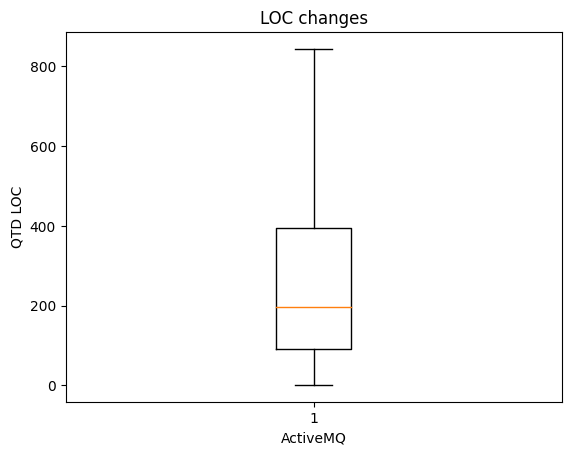

In [49]:
fig1, ax1 = pyplot.subplots()
ax1.set_title('LOC changes')
ax1.set_xlabel('ActiveMQ')
ax1.set_ylabel('QTD LOC')
ax1.boxplot(x=df_commit_diffs_satd.lines, showfliers=False)

In [50]:
round(df_commit_diffs_satd.lines.describe(), 2)

count       942.00
mean        831.03
std        6839.68
min           1.00
25%          92.25
50%         196.50
75%         393.50
max      200690.00
Name: lines, dtype: float64

{'whiskers': [<matplotlib.lines.Line2D at 0x78757f8848e0>,
 'caps': [<matplotlib.lines.Line2D at 0x78757f8852d0>,
 'boxes': [<matplotlib.lines.Line2D at 0x78757f886f20>],
 'medians': [<matplotlib.lines.Line2D at 0x78757f81d360>],
 'fliers': [],
 'means': []}

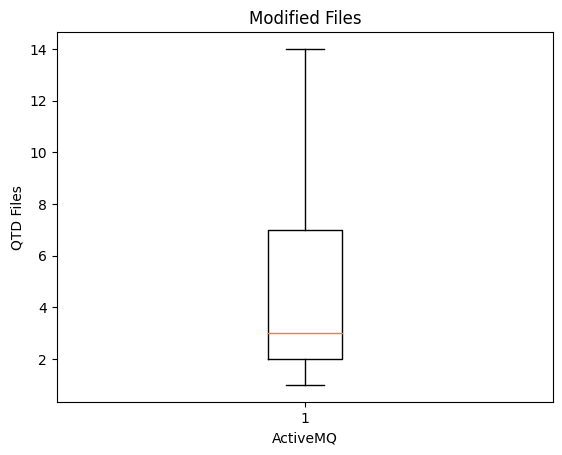

In [51]:
fig1, ax1 = pyplot.subplots()
ax1.set_title('Modified Files')
ax1.set_xlabel('ActiveMQ')
ax1.set_ylabel('QTD Files')
ax1.boxplot(x=df_commit_diffs_satd.files, showfliers=False)

In [52]:
round(df_commit_diffs_satd.files.describe(), 2)

count    942.00
mean       9.62
std       36.66
min        1.00
25%        2.00
50%        3.00
75%        7.00
max      807.00
Name: files, dtype: float64

In [53]:
df_commit_diffs_satd.to_excel('activemq_diffs_satd.xlsx', index=False)

### Commits with Critical Classes diffs with SATD

In [54]:
print('Conjunto de commits com classes críticas: ')
print(f'{len(set_only_commits_critical_classes)}')

Conjunto de commits com classes críticas: 
721


In [55]:
df_commits_with_critical_classes_with_satd = df_commit_diffs_satd[df_commit_diffs_satd.commit.isin(set_only_commits_critical_classes)]
df_commits_with_critical_classes_with_satd

,commit,msg,lines,files,keywords,comments
4,977393d9e74364c21260f00d2fe0e314c77f9afa,fix for http://issues.apache.org/activemq/brow...,170,4,[test],[ * Test cases used to test the JMS message co...
6,3b08860f10a12b8753e24756cf66f4a8d66b270e,resolve https://issues.apache.org/activemq/bro...,12202,129,"[output, output, output, output, output, outpu...",[ * Write a object instance to data output...
19,9216c18c73e3bf5d755dff963750f08106423b56,little refactor of recovery dispatch as now on...,252,4,[test],[ * change the order of the above test]
20,184761a119ae684a910bed41bc0f81bc2334fdb4,"tidy up redispatch logic a little more, resolv...",149,3,"[test, test]",[ // This test case does not work if op...
25,08aecbee6e9754e696f3bdf64634263dc73cb5c5,partial fix for AMQ2149|http://issues.apache.o...,290,6,[debug],[ // make the queue easily visible in the d...
...,...,...,...,...,...,...
921,58666afffde7eb43509d155e709e76e6fdba8084,AMQ-9156 - Make sure in flight metrics are pro...,101,3,"[clean, clean, clean, clean, clean, clean, cle...",[ //Metrics will ge...
925,ed924cddac90b96bdc47b215852a68155d818bcd,AMQ-9202 - Make sure Reentrant locks are acqui...,86,3,[interface],[ //PersistenceAdapter interface by...
928,c41be2a8d765448b825c50388b1c5c137593194a,[AMQ-8316] Flag deprecated methods in BrokerSe...,31,1,"[rename, rename, rename, rename, rename, renam...",[ * @deprecated this method will be rename...
931,901956d4ddb6a0ea9fe5fedf39732117ab68f087,AMQ-9262 - Fix network subscriptions for compo...,619,5,"[clean, cleanup, test, fix, test, exception, t...","[ //Verify cleanup, //Verify cl..."


In [56]:
round(df_commits_with_critical_classes_with_satd.describe(), 2)

,lines,files
count,155.00,155.00
mean,611.52,15.15
std,1448.85,49.19
min,6.00,1.00
25%,155.00,3.00
50%,251.00,5.00
75%,464.00,11.50
max,12202.00,570.00


## Analisa Commits sem SATD

### Analisa todos os diffs (added) dos commits entre 1/01/2009 e 4/10/2023 do ActiveMQ que SEM as SATD.

In [57]:
dict_commit_diffs_no_satd = my_satd_commit_analyzer.analyze_commit_diffs_for_no_satd(start_date, end_date, final_satd_keywords)

Aguarde...


Progress SATD diff commit analysis: 100%|██████████| 7941/7941 [02:51<00:00, 46.18it/s]


In [58]:
df_commit_diffs_no_satd = create_df_commits_diffs_no_satd(dict_commit_diffs_no_satd)

In [59]:
df_commit_diffs_no_satd

,commits,msg,lines,files,comments
0,78c002f5686b5ab724f0943b199b4f9ebc45ea66,AMQ-2052 more better fixes of where to make th...,38,4,"[ * @param type ""PERSISTENT"" or ""VM"", ..."
1,f62737be7caa75e179dee1f6b081632668dd06af,Moving stuff around so that activemq-core can ...,4462,42,"[ //| option java_implments = ""org.apache.act..."
2,d8c14e075ffc54385c2a6817758e9afd100441ba,make use of 'this' more consistent and fix a c...,24,1,[ * @param maxItems maximum number of mess...
3,e2c83d6fb6355dcf65821268cd1843ff603dc5f9,Remove some dangerous method calls from the co...,71,1,"[ * @param broker Broker for this cursor, ..."
4,34acbdc154fc5dc6d484cbc075e8394843f97b96,"minor generics, import, and javadoc cleanup\n\...",12,1,"[ * @param context broker context, * ..."
...,...,...,...,...,...
2831,e10d457868f851af96e9aa899c8840c0d5514d76,[AMQ-9239] jakarta.jms - assembly changes,262,40,[ // AMQ-9239 - setEnv doesn't work w/ ...
2832,9f374dfcb50729693ae1ee55d58bfea27fef1c0a,[AMQ-9301] Add additional fields to o.a.active...,32,2,"[ /**, * @return true if the Connectio..."
2833,09ae41adec4b538ea372e00e95e47df06e669efe,[AMQ-8325] JMS 2.0 XA supported operations,361,9,"[/**, * Licensed to the Apache Software Found..."
2834,538b04aa0c18f61cd47b261c7372a3e559c2ca0e,[AMQ-9255] Initialize the transient field of t...,167,3,"[ /**, * Initialize the transient fiel..."


In [60]:
round(df_commit_diffs_no_satd.describe(), 2)

,lines,files
count,2836.00,2836.00
mean,371.67,7.04
std,3946.10,40.64
min,1.00,1.00
25%,45.00,2.00
50%,117.00,3.00
75%,242.25,5.00
max,200690.00,1109.00


In [61]:
df_commit_diffs_no_satd.to_excel('kafka_commit_diffs_no_satd.xlsx', index=False)

{'whiskers': [<matplotlib.lines.Line2D at 0x78757e0ae8c0>,
 'caps': [<matplotlib.lines.Line2D at 0x78757e0adfc0>,
 'boxes': [<matplotlib.lines.Line2D at 0x78757e0aefe0>],
 'medians': [<matplotlib.lines.Line2D at 0x78757e0ad810>],
 'fliers': [],
 'means': []}

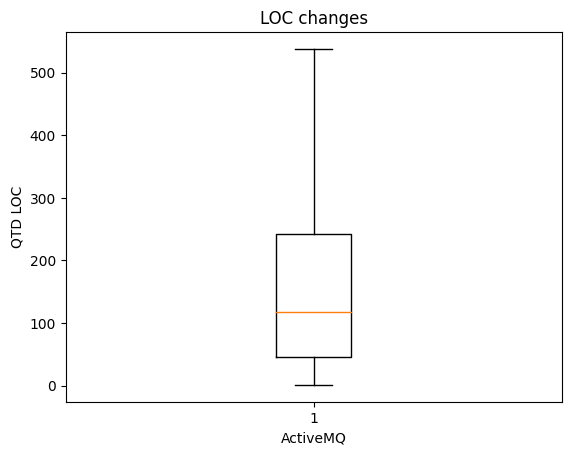

In [62]:
fig1, ax1 = pyplot.subplots()
ax1.set_title('LOC changes')
ax1.set_xlabel('ActiveMQ')
ax1.set_ylabel('QTD LOC')
ax1.boxplot(x=df_commit_diffs_no_satd.lines, showfliers=False)

In [63]:
round(df_commit_diffs_no_satd.lines.describe(), 2)

count      2836.00
mean        371.67
std        3946.10
min           1.00
25%          45.00
50%         117.00
75%         242.25
max      200690.00
Name: lines, dtype: float64

{'whiskers': [<matplotlib.lines.Line2D at 0x78757ddf7fd0>,
 'caps': [<matplotlib.lines.Line2D at 0x78757ddf4520>,
 'boxes': [<matplotlib.lines.Line2D at 0x78757ddf6ef0>],
 'medians': [<matplotlib.lines.Line2D at 0x78757ddf7ac0>],
 'fliers': [],
 'means': []}

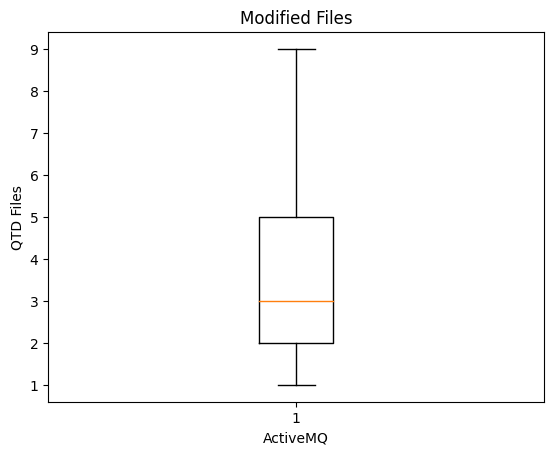

In [64]:
fig1, ax1 = pyplot.subplots()
ax1.set_title('Modified Files')
ax1.set_xlabel('ActiveMQ')
ax1.set_ylabel('QTD Files')
ax1.boxplot(x=df_commit_diffs_no_satd.files, showfliers=False)

In [65]:
round(df_commit_diffs_no_satd.files.describe(), 2)

count    2836.00
mean        7.04
std        40.64
min         1.00
25%         2.00
50%         3.00
75%         5.00
max      1109.00
Name: files, dtype: float64

In [66]:
df_commits_with_critical_classes_no_satd = df_commit_diffs_no_satd[df_commit_diffs_no_satd.commits.isin(set_only_commits_critical_classes)]
df_commits_with_critical_classes_no_satd

,commits,msg,lines,files,comments
5,07b6a38336a62913d42817a89cdc821a89419b7f,AMQ-2053 introduce methods to remove (closed) ...,164,12,"[ * @param context connection context, ..."
16,807f64591dcd4e0e496dc5795405812129d0d062,Recovery dispatch refactoring as the part of t...,54,2,[ // do recovery dispatch only if i...
17,a321204079f435deaf8d082fb3de95c5c792c7f2,fix for http://issues.apache.org/activemq/brow...,317,3,[ // If we are cursoring to disk..it's ...
18,977393d9e74364c21260f00d2fe0e314c77f9afa,fix for http://issues.apache.org/activemq/brow...,170,4,"[/*, * Test plan:, * Producer: publish messa..."
21,39dd6b914a6954bf8f7114e97831482fd616e8bb,fix for https://issues.apache.org/activemq/bro...,238,4,"[/**, * Licensed to the Apache Software Found..."
...,...,...,...,...,...
2801,ed924cddac90b96bdc47b215852a68155d818bcd,AMQ-9202 - Make sure Reentrant locks are acqui...,86,3,[ //acquire the checkpoint lock to ...
2811,c41be2a8d765448b825c50388b1c5c137593194a,[AMQ-8316] Flag deprecated methods in BrokerSe...,31,1,"[ /**, */, *, /**, * @de..."
2818,901956d4ddb6a0ea9fe5fedf39732117ab68f087,AMQ-9262 - Fix network subscriptions for compo...,619,5,[ // If we have an entry in composi...
2820,3ba93ed9579bbe90967312fba78726d96239110a,Remove unnecessary boxing / unboxing,1307,111,"[ /**, *]"


In [67]:
round(df_commits_with_critical_classes_no_satd.describe(), 2)

,lines,files
count,471.00,471.00
mean,362.30,15.50
std,882.43,82.53
min,3.00,1.00
25%,81.50,2.00
50%,183.00,4.00
75%,326.50,8.50
max,12202.00,1109.00


# Comparing Commits with SATD and Commits without SATD

## Geral


### LOC changes

<ipython-input-68-e25d0a6ffd2d>:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(['a1 (SATD)', 'a2 (No SATD)'])


{'whiskers': [<matplotlib.lines.Line2D at 0x78757de9c790>,
 'caps': [<matplotlib.lines.Line2D at 0x78757de9fc10>,
 'boxes': [<matplotlib.lines.Line2D at 0x78757de9e2f0>,
 'medians': [<matplotlib.lines.Line2D at 0x78757de9c880>,
 'fliers': [],
 'means': []}

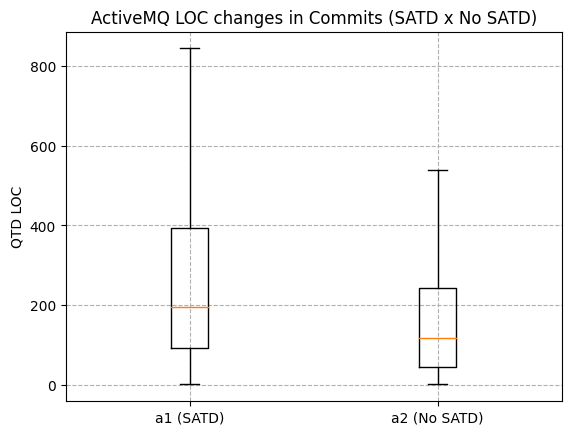

In [68]:
data_lines = [df_commit_diffs_satd.lines, df_commit_diffs_no_satd.lines]
fig1, ax1 = pyplot.subplots()
ax1.set_title('ActiveMQ LOC changes in Commits (SATD x No SATD)')
ax1.set_xticklabels(['a1 (SATD)', 'a2 (No SATD)'])
ax1.set_ylabel('QTD LOC')
ax1.grid(linestyle='--')
ax1.boxplot(x=data_lines, showfliers=False)

### Modified Files

<ipython-input-69-0adb8e030454>:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(['a1 (SATD)', 'a2 (No SATD)'])


{'whiskers': [<matplotlib.lines.Line2D at 0x78757dee7070>,
 'caps': [<matplotlib.lines.Line2D at 0x78757dee6650>,
 'boxes': [<matplotlib.lines.Line2D at 0x78757dee5c30>,
 'medians': [<matplotlib.lines.Line2D at 0x78757dee6bc0>,
 'fliers': [],
 'means': []}

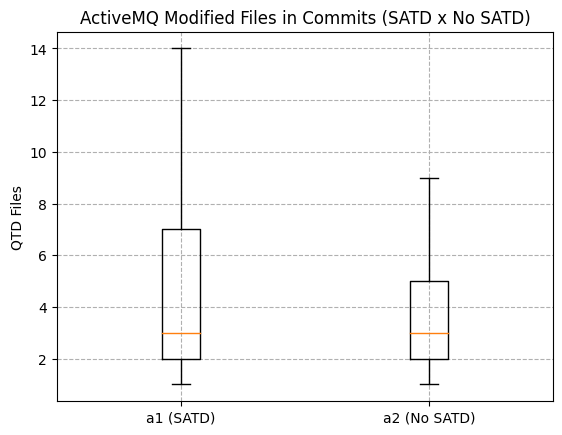

In [69]:
data_files = [df_commit_diffs_satd.files, df_commit_diffs_no_satd.files]
fig1, ax1 = pyplot.subplots()
ax1.set_title('ActiveMQ Modified Files in Commits (SATD x No SATD)')
ax1.set_xticklabels(['a1 (SATD)', 'a2 (No SATD)'])
ax1.set_ylabel('QTD Files')
ax1.grid(linestyle='--')
ax1.boxplot(x=data_files, showfliers=False)

## Commits with Critical Classes

### Geral

**LOC changes**

<ipython-input-70-972705c28e7f>:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(['a1 (SATD)', 'a2 (No SATD)'])


{'whiskers': [<matplotlib.lines.Line2D at 0x78757e76dc60>,
 'caps': [<matplotlib.lines.Line2D at 0x78757e76c1c0>,
 'boxes': [<matplotlib.lines.Line2D at 0x78757e76e1a0>,
 'medians': [<matplotlib.lines.Line2D at 0x78757e76d4b0>,
 'fliers': [],
 'means': []}

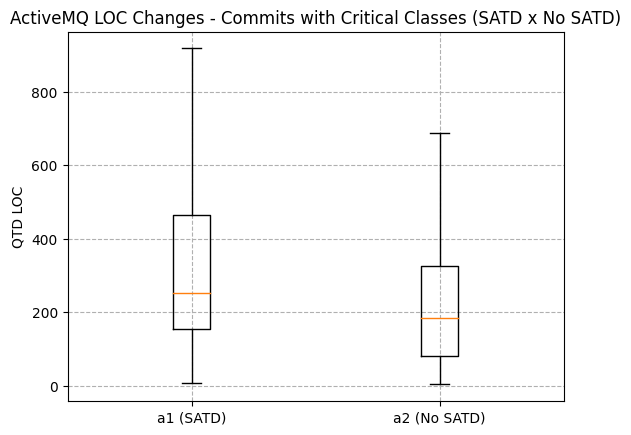

In [70]:
data_commits_cc_lines = df_commits_with_critical_classes_with_satd.lines, df_commits_with_critical_classes_no_satd.lines
fig1, ax1 = pyplot.subplots()
ax1.set_title('ActiveMQ LOC Changes - Commits with Critical Classes (SATD x No SATD)')
ax1.set_xticklabels(['a1 (SATD)', 'a2 (No SATD)'])
ax1.set_ylabel('QTD LOC')
ax1.grid(linestyle='--')
ax1.boxplot(x=data_commits_cc_lines, showfliers=False)

**Modified files**

<ipython-input-71-a0dc8affba34>:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(['a1 (SATD)', 'a2 (No SATD)'])


{'whiskers': [<matplotlib.lines.Line2D at 0x78757e004bb0>,
 'caps': [<matplotlib.lines.Line2D at 0x78757e004280>,
 'boxes': [<matplotlib.lines.Line2D at 0x78757e007910>,
 'medians': [<matplotlib.lines.Line2D at 0x78757e007b50>,
 'fliers': [],
 'means': []}

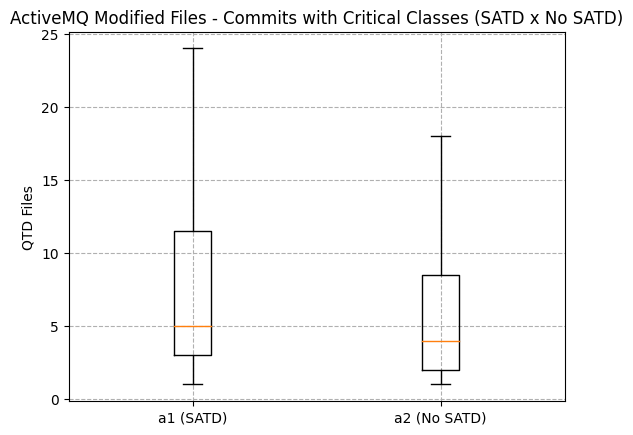

In [71]:
data_commits_cc_files = df_commits_with_critical_classes_with_satd.files, df_commits_with_critical_classes_no_satd.files
fig1, ax1 = pyplot.subplots()
ax1.set_title('ActiveMQ Modified Files - Commits with Critical Classes (SATD x No SATD)')
ax1.set_xticklabels(['a1 (SATD)', 'a2 (No SATD)'])
ax1.set_ylabel('QTD Files')
ax1.grid(linestyle='--')
ax1.boxplot(x=data_commits_cc_files, showfliers=False)

### Issues in commits

In [74]:
df_issues_in_commits_with_critical_classes_with_satd = df_commits_with_critical_classes_with_satd[df_commits_with_critical_classes_with_satd.commit.isin(list_commits_with_critical_classes_with_issues)]
df_issues_in_commits_with_critical_classes_with_satd

,commit,msg,lines,files,keywords,comments
4,977393d9e74364c21260f00d2fe0e314c77f9afa,fix for http://issues.apache.org/activemq/brow...,170,4,[test],[ * Test cases used to test the JMS message co...
6,3b08860f10a12b8753e24756cf66f4a8d66b270e,resolve https://issues.apache.org/activemq/bro...,12202,129,"[output, output, output, output, output, outpu...",[ * Write a object instance to data output...
20,184761a119ae684a910bed41bc0f81bc2334fdb4,"tidy up redispatch logic a little more, resolv...",149,3,"[test, test]",[ // This test case does not work if op...
25,08aecbee6e9754e696f3bdf64634263dc73cb5c5,partial fix for AMQ2149|http://issues.apache.o...,290,6,[debug],[ // make the queue easily visible in the d...
26,132f662209f7e25a1d9c240fdddcf61e0ed1226c,resolve AMQ-2149|https://issues.apache.org/act...,326,21,[test],[ // no need to run this unless there are i...
...,...,...,...,...,...,...
921,58666afffde7eb43509d155e709e76e6fdba8084,AMQ-9156 - Make sure in flight metrics are pro...,101,3,"[clean, clean, clean, clean, clean, clean, cle...",[ //Metrics will ge...
925,ed924cddac90b96bdc47b215852a68155d818bcd,AMQ-9202 - Make sure Reentrant locks are acqui...,86,3,[interface],[ //PersistenceAdapter interface by...
928,c41be2a8d765448b825c50388b1c5c137593194a,[AMQ-8316] Flag deprecated methods in BrokerSe...,31,1,"[rename, rename, rename, rename, rename, renam...",[ * @deprecated this method will be rename...
931,901956d4ddb6a0ea9fe5fedf39732117ab68f087,AMQ-9262 - Fix network subscriptions for compo...,619,5,"[clean, cleanup, test, fix, test, exception, t...","[ //Verify cleanup, //Verify cl..."


In [75]:
round(df_issues_in_commits_with_critical_classes_with_satd.describe(), 2)

,lines,files
count,141.00,141.00
mean,612.52,15.26
std,1507.71,51.07
min,6.00,1.00
25%,158.00,3.00
50%,249.00,5.00
75%,437.00,11.00
max,12202.00,570.00


In [76]:
df_issues_in_commits_with_critical_classes_no_satd = df_commits_with_critical_classes_no_satd[df_commits_with_critical_classes_no_satd.commits.isin(list_commits_with_critical_classes_with_issues)]
df_issues_in_commits_with_critical_classes_no_satd

,commits,msg,lines,files,comments
5,07b6a38336a62913d42817a89cdc821a89419b7f,AMQ-2053 introduce methods to remove (closed) ...,164,12,"[ * @param context connection context, ..."
16,807f64591dcd4e0e496dc5795405812129d0d062,Recovery dispatch refactoring as the part of t...,54,2,[ // do recovery dispatch only if i...
17,a321204079f435deaf8d082fb3de95c5c792c7f2,fix for http://issues.apache.org/activemq/brow...,317,3,[ // If we are cursoring to disk..it's ...
18,977393d9e74364c21260f00d2fe0e314c77f9afa,fix for http://issues.apache.org/activemq/brow...,170,4,"[/*, * Test plan:, * Producer: publish messa..."
21,39dd6b914a6954bf8f7114e97831482fd616e8bb,fix for https://issues.apache.org/activemq/bro...,238,4,"[/**, * Licensed to the Apache Software Found..."
...,...,...,...,...,...
2794,757a712890996d71cf380c56fc2cefbd5a82ec88,AMQ-9168 - Send message expired advisory and n...,199,3,[ //Expired...
2801,ed924cddac90b96bdc47b215852a68155d818bcd,AMQ-9202 - Make sure Reentrant locks are acqui...,86,3,[ //acquire the checkpoint lock to ...
2811,c41be2a8d765448b825c50388b1c5c137593194a,[AMQ-8316] Flag deprecated methods in BrokerSe...,31,1,"[ /**, */, *, /**, * @de..."
2818,901956d4ddb6a0ea9fe5fedf39732117ab68f087,AMQ-9262 - Fix network subscriptions for compo...,619,5,[ // If we have an entry in composi...


In [77]:
round(df_issues_in_commits_with_critical_classes_no_satd.describe(), 2)

,lines,files
count,433.00,433.00
mean,349.46,9.16
std,903.48,30.06
min,3.00,1.00
25%,82.00,2.00
50%,179.00,4.00
75%,315.00,8.00
max,12202.00,570.00


**LOC changes**

<ipython-input-78-865ee2f1bdb8>:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(['a1 (SATD)', 'a2 (No SATD)'])


{'whiskers': [<matplotlib.lines.Line2D at 0x78757dd00730>,
 'caps': [<matplotlib.lines.Line2D at 0x78757dd02740>,
 'boxes': [<matplotlib.lines.Line2D at 0x78757dd00970>,
 'medians': [<matplotlib.lines.Line2D at 0x78757dd01690>,
 'fliers': [],
 'means': []}

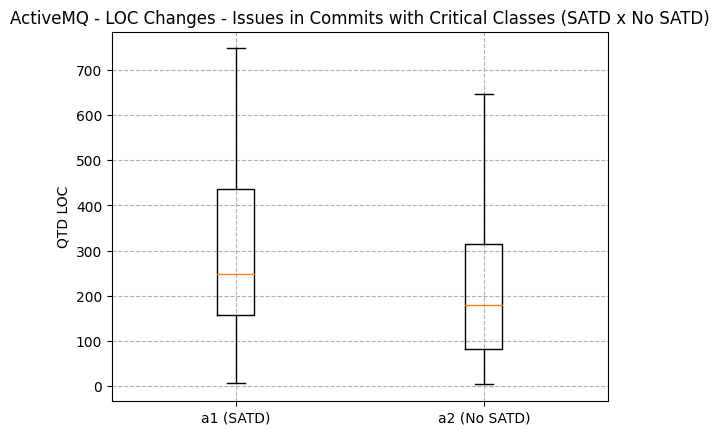

In [78]:
data_issues_commits_cc_lines = df_issues_in_commits_with_critical_classes_with_satd.lines, df_issues_in_commits_with_critical_classes_no_satd.lines
fig1, ax1 = pyplot.subplots()
ax1.set_title('ActiveMQ - LOC Changes - Issues in Commits with Critical Classes (SATD x No SATD)')
ax1.set_xticklabels(['a1 (SATD)', 'a2 (No SATD)'])
ax1.set_ylabel('QTD LOC')
ax1.grid(linestyle='--')
ax1.boxplot(x=data_issues_commits_cc_lines, showfliers=False)

**Modified Files**

<ipython-input-79-5b492627df63>:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(['a1 (SATD)', 'a2 (No SATD)'])


{'whiskers': [<matplotlib.lines.Line2D at 0x78757ddfd480>,
 'caps': [<matplotlib.lines.Line2D at 0x78757ddffa00>,
 'boxes': [<matplotlib.lines.Line2D at 0x78757ddfcdf0>,
 'medians': [<matplotlib.lines.Line2D at 0x78757ddfe4d0>,
 'fliers': [],
 'means': []}

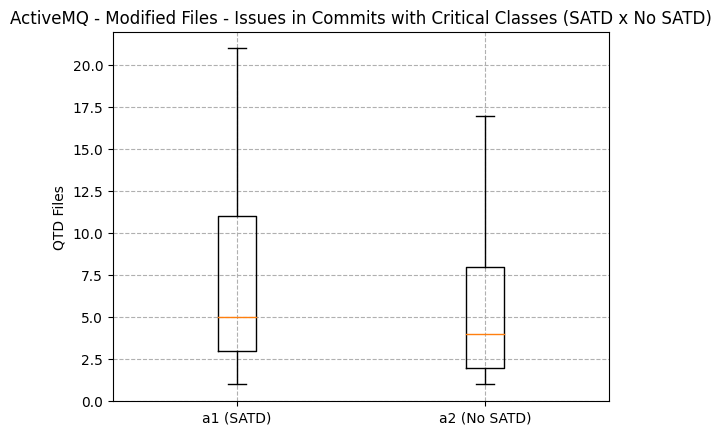

In [79]:
data_issues_commits_cc_files = df_issues_in_commits_with_critical_classes_with_satd.files, df_issues_in_commits_with_critical_classes_no_satd.files
fig1, ax1 = pyplot.subplots()
ax1.set_title('ActiveMQ - Modified Files - Issues in Commits with Critical Classes (SATD x No SATD)')
ax1.set_xticklabels(['a1 (SATD)', 'a2 (No SATD)'])
ax1.set_ylabel('QTD Files')
ax1.grid(linestyle='--')
ax1.boxplot(x=data_issues_commits_cc_files, showfliers=False)

## Commits without Critical Classes

In [80]:
print('Commits sem classes críticas: ', len(list_commits_no_critical_classes))

Commits sem classes críticas:  7220


In [81]:
dict_commits_no_critical_classes = {}
for k, v in all_commits.items():
  if k in list_commits_no_critical_classes:
    dict_commits_no_critical_classes[k] = v

print(len(dict_commits_no_critical_classes))

7220


In [82]:
df_commits_no_critical_classes = convert_commits_to_dataframe2(dict_commits_no_critical_classes)
df_commits_no_critical_classes

,hash,msg,date,lines,files,modified_files,diff_modified_files
0,13d692ebde6732870e90f1b6ca95c21054e20e55,AMQ-2052 Be careful about when to use a file-s...,1/1/2009,53,2,"[ContainerId.java, KahaStore.java]","[{'ContainerId.java': '@@ -21,6 +21,8 @@ impor..."
1,f27bd3c491de5c2ddd77515b30e9d097ec6f2490,AMQ-2052 Throw an exception when references to...,1/1/2009,3,1,[RecoveryListenerAdapter.java],"[{'RecoveryListenerAdapter.java': '@@ -55,9 +5..."
2,78c002f5686b5ab724f0943b199b4f9ebc45ea66,AMQ-2052 more better fixes of where to make th...,1/1/2009,38,4,"[ContainerId.java, KahaStore.java, AsyncDataMa...","[{'ContainerId.java': '@@ -80,8 +80,4 @@ publi..."
3,8a857bdc0111d879e47efe9d651559c89b3768c7,AMQ-2052 another file name problem\n\ngit-svn-...,2/1/2009,7,2,"[DataFile.java, DataManagerImpl.java]","[{'DataFile.java': '@@ -28,8 +28,8 @@ import j..."
4,4199c950986accb688f04608f4943885a8347a06,improvement for https://issues.apache.org/acti...,5/1/2009,5,1,[AuthorizationBroker.java],"[{'AuthorizationBroker.java': '@@ -54,11 +54,9..."
...,...,...,...,...,...,...,...
7215,5f62d5d67f47f9a634d939e6f43d112a17b3e0ba,[AMQ-9311] Remove support for JDK less than 17...,29/9/2023,116,4,"[activemq, wrapper.conf, wrapper.conf, wrapper...","[{'activemq': '@@ -336,8 +336,7 @@ invokeJar()..."
7216,7215057bc57386c76e84c65a4b11defa01dc0b9f,Merge pull request #1058 from jbonofre/AMQ-931...,29/9/2023,2,1,[],[]
7217,b9a8bbd142cec614f7c2ce3c32e784a94ec3d847,Merge pull request #1059 from jbonofre/AMQ-931...,2/10/2023,2,1,[],[]
7218,538b04aa0c18f61cd47b261c7372a3e559c2ca0e,[AMQ-9255] Initialize the transient field of t...,3/10/2023,167,3,"[ActiveMQMapMessage.java, Message.java, AMQ925...","[{'ActiveMQMapMessage.java': '@@ -104,7 +104,9..."


In [83]:
round(df_commits_no_critical_classes.describe(), 2)

,lines,files
count,7220.00,7220.00
mean,170.01,4.24
std,2536.56,30.46
min,0.00,0.00
25%,4.00,1.00
50%,19.00,1.00
75%,84.00,3.00
max,200690.00,1475.00


In [84]:
list_commits_no_critical_classes = df_commits_no_critical_classes.hash.to_list()
print(len(list_commits_no_critical_classes))

7220


### Commits sem critical classes com SATD

In [85]:
df_commits_without_critical_classes_with_satd = df_commit_diffs_satd[df_commit_diffs_satd.commit.isin(list_commits_no_critical_classes)]
df_commits_without_critical_classes_with_satd

,commit,msg,lines,files,keywords,comments
0,e2c83d6fb6355dcf65821268cd1843ff603dc5f9,Remove some dangerous method calls from the co...,71,1,"[TODO, constructor]",[ //TODO is this correct? we are ignori...
1,8b9e755035c0cd901da6083f48f53b9ad2f763e4,resolve AMQ-2062 - add setExceptionListener to...,25,1,"[exception, exception, exception]","[ * an exception listener., * <p> Not..."
2,f1d59cd2cd236dee5d78520a0c607ef289a9dfa9,add test case to exercise producerFlowControl ...,163,2,"[exception, test, exception]","[ // with async send, t..."
3,1f00a395f895751cc8d50eccd335b004c0f77012,AMQ-2078 extend transaction tests to xa in ra\...,349,4,"[test, test, test, test, comment]",[ * This test only works with local transa...
5,02ca463bf8898834da4b6bb6e5f8451d24278077,disable a bunch of ra xa tests pending some in...,10,1,"[TODO, fix]","[ // TODO fix for XA, // TODO fix for XA]"
...,...,...,...,...,...,...
937,5473ea58e523db0410e743369aead7e5b3bf4342,"[AMQ-9239] jakarta.jms - activemq-ra, activemq...",1008,42,"[TODO, TODO, TODO, TODO, TODO, TODO, TODO, TOD...",[ // TODO Auto-generated method...
938,af07efe27daff274d3cdf9b51174533626731810,[AMQ-9239] jakarta.jms - activemq-spring changes,1253,26,"[TODO, TODO, TODO, TODO, TODO, TODO, support f...",[ // TODO Auto-gene...
939,65267a9a158938f3e6c1c2dcec7610dec607c55a,[AMQ-9239] jakarta.jms - activemq-unit-tests c...,9051,807,[FIXME],[ /** // AMQ-9239 FIXME: byte-buddy module ...
940,90fbd9098bacae2f0150fad33b7c15f1ed42c5cb,"[AMQ-9239] jakarta.jms - activemq-web-console,...",536,63,"[TODO, API, annotation]",[ // [AMQ-9239] TODO: Confirm jakarta S...


In [86]:
round(df_commits_without_critical_classes_with_satd.describe(), 2)

,lines,files
count,787.00,787.00
mean,874.26,8.53
std,7455.46,33.58
min,1.00,1.00
25%,84.50,2.00
50%,181.00,3.00
75%,373.00,6.00
max,200690.00,807.00


### Commits sem critical classes e sem SATD

In [87]:
df_commits_without_critical_classes_no_satd = df_commit_diffs_no_satd[df_commit_diffs_no_satd.commits.isin(list_commits_no_critical_classes)]
df_commits_without_critical_classes_no_satd

,commits,msg,lines,files,comments
0,78c002f5686b5ab724f0943b199b4f9ebc45ea66,AMQ-2052 more better fixes of where to make th...,38,4,"[ * @param type ""PERSISTENT"" or ""VM"", ..."
1,f62737be7caa75e179dee1f6b081632668dd06af,Moving stuff around so that activemq-core can ...,4462,42,"[ //| option java_implments = ""org.apache.act..."
2,d8c14e075ffc54385c2a6817758e9afd100441ba,make use of 'this' more consistent and fix a c...,24,1,[ * @param maxItems maximum number of mess...
3,e2c83d6fb6355dcf65821268cd1843ff603dc5f9,Remove some dangerous method calls from the co...,71,1,"[ * @param broker Broker for this cursor, ..."
4,34acbdc154fc5dc6d484cbc075e8394843f97b96,"minor generics, import, and javadoc cleanup\n\...",12,1,"[ * @param context broker context, * ..."
...,...,...,...,...,...
2831,e10d457868f851af96e9aa899c8840c0d5514d76,[AMQ-9239] jakarta.jms - assembly changes,262,40,[ // AMQ-9239 - setEnv doesn't work w/ ...
2832,9f374dfcb50729693ae1ee55d58bfea27fef1c0a,[AMQ-9301] Add additional fields to o.a.active...,32,2,"[ /**, * @return true if the Connectio..."
2833,09ae41adec4b538ea372e00e95e47df06e669efe,[AMQ-8325] JMS 2.0 XA supported operations,361,9,"[/**, * Licensed to the Apache Software Found..."
2834,538b04aa0c18f61cd47b261c7372a3e559c2ca0e,[AMQ-9255] Initialize the transient field of t...,167,3,"[ /**, * Initialize the transient fiel..."


In [88]:
round(df_commits_without_critical_classes_no_satd.describe(), 2)

,lines,files
count,2365.00,2365.00
mean,373.54,5.36
std,4303.42,24.69
min,1.00,1.00
25%,41.00,1.00
50%,106.00,2.00
75%,224.00,4.00
max,200690.00,807.00


### Testes dos commits sem critical classes

**LOC changes**

<ipython-input-89-0980cd9549ac>:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(['a1 (SATD)', 'a2 (No SATD)'])


{'whiskers': [<matplotlib.lines.Line2D at 0x78757e48a170>,
 'caps': [<matplotlib.lines.Line2D at 0x78757e489540>,
 'boxes': [<matplotlib.lines.Line2D at 0x78757e48a8f0>,
 'medians': [<matplotlib.lines.Line2D at 0x78757e79cfd0>,
 'fliers': [],
 'means': []}

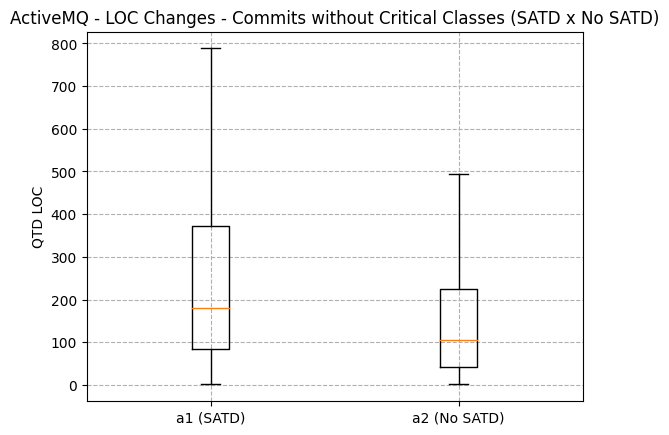

In [89]:
data_commits_no_cc_lines = df_commits_without_critical_classes_with_satd.lines, df_commits_without_critical_classes_no_satd.lines

fig1, ax1 = pyplot.subplots()

ax1.set_title('ActiveMQ - LOC Changes - Commits without Critical Classes (SATD x No SATD)')
ax1.set_xticklabels(['a1 (SATD)', 'a2 (No SATD)'])
ax1.set_ylabel('QTD LOC')
ax1.grid(linestyle='--')

ax1.boxplot(x=data_commits_no_cc_lines, showfliers=False)

**Modified Files**

<ipython-input-90-15857409c270>:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(['a1 (SATD)', 'a2 (No SATD)'])


{'whiskers': [<matplotlib.lines.Line2D at 0x78757ddf8b50>,
 'caps': [<matplotlib.lines.Line2D at 0x78757ddfa230>,
 'boxes': [<matplotlib.lines.Line2D at 0x78757ddf87f0>,
 'medians': [<matplotlib.lines.Line2D at 0x78757ddfb520>,
 'fliers': [],
 'means': []}

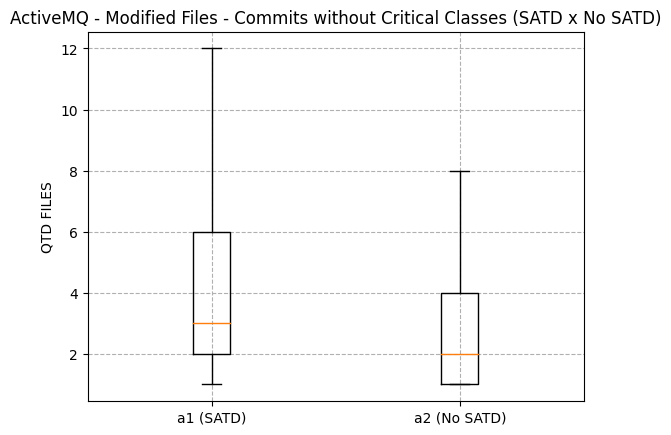

In [90]:
data_commits_no_cc_files = df_commits_without_critical_classes_with_satd.files, df_commits_without_critical_classes_no_satd.files

fig1, ax1 = pyplot.subplots()

ax1.set_title('ActiveMQ - Modified Files - Commits without Critical Classes (SATD x No SATD)')
ax1.set_xticklabels(['a1 (SATD)', 'a2 (No SATD)'])
ax1.set_ylabel('QTD FILES')
ax1.grid(linestyle='--')

ax1.boxplot(x=data_commits_no_cc_files, showfliers=False)